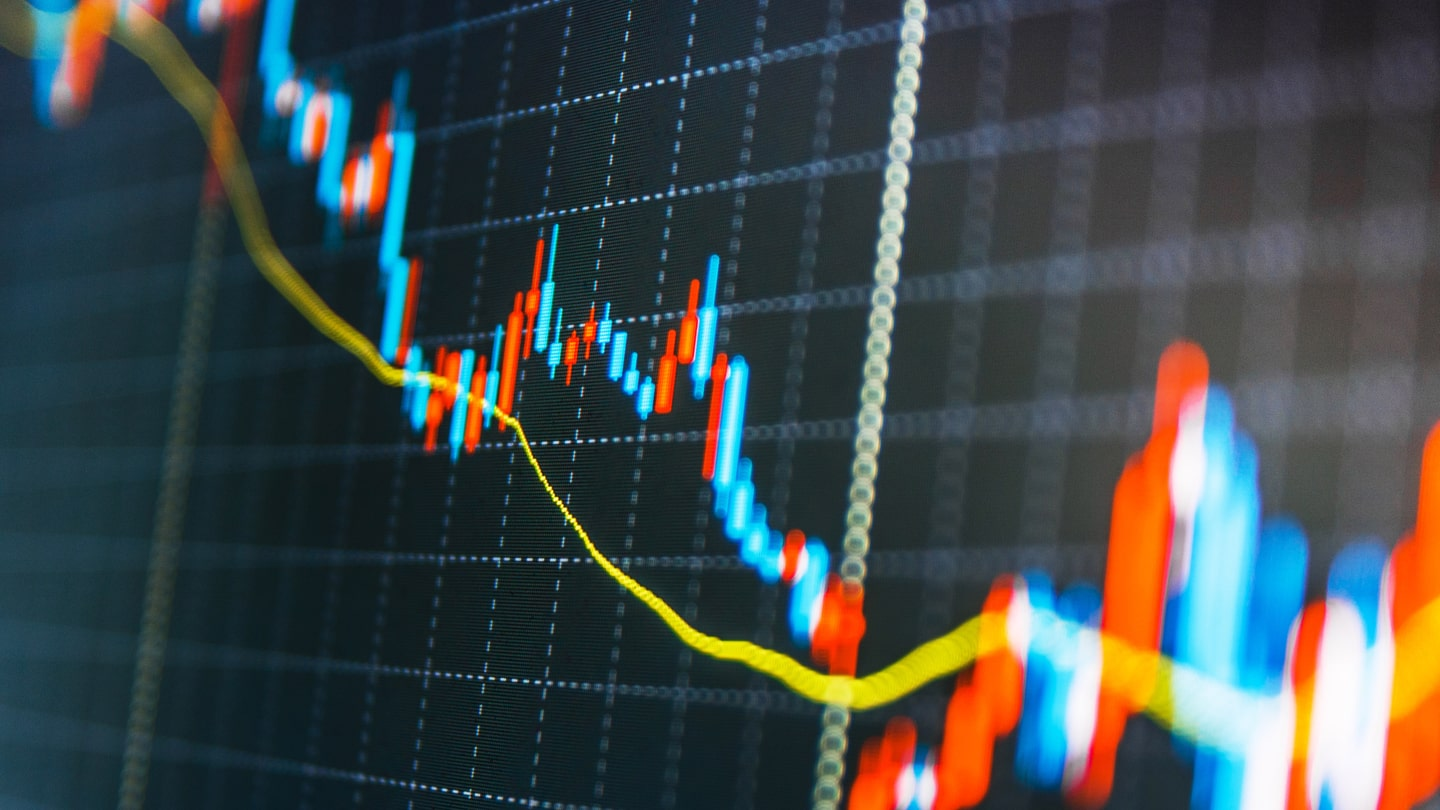

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import date



#from statsmodels.tsa.stattools import adfuller
#from statsmodels.tsa.seasonal import seasonal_decompose
#from statsmodels.tsa.arima_model import ARIMA
#from pandas.plotting import register_matplotlib_converters
#register_matplotlib_converters()

In [2]:
from nsepy import get_history
nifty = get_history(symbol="NIFTY",
                    start=date(2000,1,1),
                    end=date.today(),
                    index=True)
nifty.tail()

Open      High       Low     Close     Volume      Turnover
Date                                                                       
2022-05-24  16225.55  16262.80  16078.60  16125.15  249778296  2.189575e+11
2022-05-25  16196.35  16223.35  16006.95  16025.80  243342347  2.140014e+11
2022-05-26  16105.00  16204.45  15903.70  16170.15  314305739  2.772121e+11
2022-05-27  16296.60  16370.60  16221.95  16352.45  274064956  2.134198e+11
2022-05-30  16527.90  16695.50  16506.15  16661.40  251400757  2.121650e+11

In [3]:
from nsepy import get_index_pe_history
nifty_pe = get_index_pe_history(symbol="NIFTY",
                                start=date(2000,1,1),
                                end=date.today())
nifty_pe.tail()

P/E   P/B  Div Yield
Date                              
2022-05-24  19.87  4.12       1.32
2022-05-25  19.74  4.09       1.38
2022-05-26  19.88  4.13       1.44
2022-05-27  20.27  4.18       1.43
2022-05-30  20.65  4.26       1.40

In [4]:
df=pd.merge(nifty, nifty_pe, left_index=True, right_index=True)
df.tail()

Open      High       Low     Close     Volume      Turnover  \
Date                                                                          
2022-05-24  16225.55  16262.80  16078.60  16125.15  249778296  2.189575e+11   
2022-05-25  16196.35  16223.35  16006.95  16025.80  243342347  2.140014e+11   
2022-05-26  16105.00  16204.45  15903.70  16170.15  314305739  2.772121e+11   
2022-05-27  16296.60  16370.60  16221.95  16352.45  274064956  2.134198e+11   
2022-05-30  16527.90  16695.50  16506.15  16661.40  251400757  2.121650e+11   

              P/E   P/B  Div Yield  
Date                                
2022-05-24  19.87  4.12       1.32  
2022-05-25  19.74  4.09       1.38  
2022-05-26  19.88  4.13       1.44  
2022-05-27  20.27  4.18       1.43  
2022-05-30  20.65  4.26       1.40

In [5]:
type(df.index)

pandas.core.indexes.base.Index

In [6]:
df.index=pd.to_datetime(df.index)

Day = nifty_pe.index.day_name()
Months = nifty_pe.index.month_name()
Years = nifty_pe.index.year
nifty_pe.insert(loc = 0,
          column = 'Day',
          value = Day)
nifty_pe.insert(loc = 1,
          column = 'Months',
          value = Months)
nifty_pe.insert(loc = 2,
          column = 'Years',
          value = Years)
nifty_pe.head()

In [8]:
data = df.asfreq('D')
data = data.fillna(data.mean(numeric_only=True))
data.shape

(8184, 9)

In [9]:
data.isin([np.nan, np.inf, -np.inf]).sum()

Open         0
High         0
Low          0
Close        0
Volume       0
Turnover     0
P/E          0
P/B          0
Div Yield    0
dtype: int64

In [10]:
dataset_len = len(data)
split_index = round(dataset_len*0.8)
train_set_end_date = data.index[split_index]

In [11]:
df_train = data.loc[data.index <= train_set_end_date].copy()
df_test = data.loc[data.index > train_set_end_date].copy()

In [12]:
df_train.shape, df_test.shape

((6548, 9), (1636, 9))

In [13]:
y_train= df_train[['P/E']]
x_train= df_train.iloc[:,0:6]
y_test= df_test[['P/E']]
x_test= df_test.iloc[:,0:6]

In [14]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((6548, 6), (6548, 1), (1636, 6), (1636, 1))

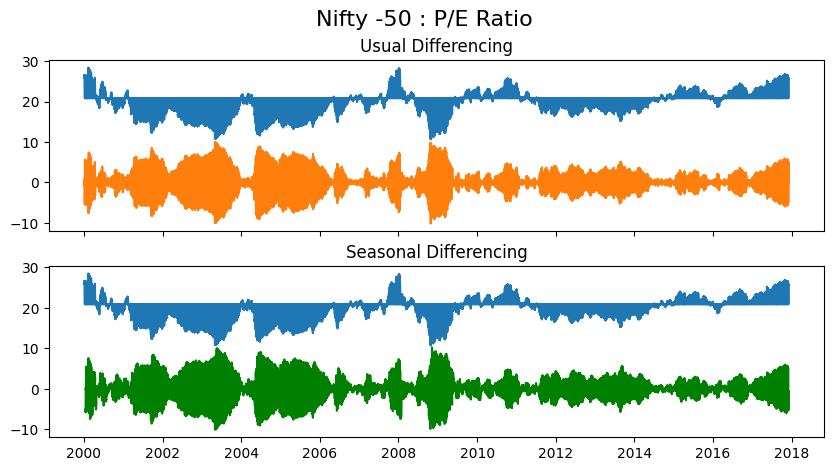

In [15]:
# Import
#data = pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/a10.csv', parse_dates=['date'], index_col='date')

# Plot
fig, axes = plt.subplots(2, 1, figsize=(10,5), dpi=100, sharex=True)

# Usual Differencing
axes[0].plot(y_train[:], label='Original Series')
axes[0].plot(y_train[:].diff(1), label='Usual Differencing')
axes[0].set_title('Usual Differencing')
#axes[0].legend(loc='upper left', fontsize=10)


# Seasinal Dei
axes[1].plot(y_train[:], label='Original Series')
axes[1].plot(y_train[:].diff(12), label='Seasonal Differencing', color='green')
axes[1].set_title('Seasonal Differencing')
#plt.legend(loc='upper left', fontsize=10)
plt.suptitle('Nifty -50 : P/E Ratio', fontsize=16)
plt.show()

In [16]:
# !pip3 install pyramid-arima
import pmdarima as pm

# Seasonal - fit stepwise auto-ARIMA
smodel = pm.auto_arima(y_train, start_p=1, start_q=1,
                         test='adf',
                         max_p=3, max_q=3, m=7,
                         start_P=0, seasonal=True,
                         d=None, D=1, trace=True,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)

smodel.summary()

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[7] intercept   : AIC=18491.792, Time=4.45 sec
 ARIMA(0,0,0)(0,1,0)[7] intercept   : AIC=20807.363, Time=0.12 sec
 ARIMA(1,0,0)(1,1,0)[7] intercept   : AIC=19278.607, Time=1.32 sec
 ARIMA(0,0,1)(0,1,1)[7] intercept   : AIC=18956.902, Time=1.61 sec
 ARIMA(0,0,0)(0,1,0)[7]             : AIC=20805.363, Time=0.11 sec
 ARIMA(1,0,1)(0,1,0)[7] intercept   : AIC=20577.652, Time=1.04 sec
 ARIMA(1,0,1)(1,1,1)[7] intercept   : AIC=18490.793, Time=6.23 sec
 ARIMA(1,0,1)(1,1,0)[7] intercept   : AIC=19160.808, Time=3.48 sec
 ARIMA(1,0,1)(2,1,1)[7] intercept   : AIC=18492.732, Time=13.02 sec
 ARIMA(1,0,1)(1,1,2)[7] intercept   : AIC=18492.811, Time=22.93 sec
 ARIMA(1,0,1)(0,1,2)[7] intercept   : AIC=18490.759, Time=17.53 sec
 ARIMA(0,0,1)(0,1,2)[7] intercept   : AIC=18956.748, Time=4.18 sec
 ARIMA(1,0,0)(0,1,2)[7] intercept   : AIC=18824.798, Time=3.49 sec
 ARIMA(2,0,1)(0,1,2)[7] intercept   : AIC=18420.645, Time=19.72 sec
 ARIMA(2,0,1)(0

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                 6548
Model:             SARIMAX(3, 0, 3)x(0, 1, [1], 7)   Log Likelihood               -9163.255
Date:                             Tue, 31 May 2022   AIC                          18342.510
Time:                                     16:32:04   BIC                          18396.797
Sample:                                          0   HQIC                         18361.280
                                            - 6548                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7400      0.013    -58.376      0.000      -0.765      -0.715
ar.L2          0.6947      0.013     53.261      0.000       0.669       0.720
ar.L3          0.7993      0.011     75.694      0.000       0.779       0.820
ma.L1          0.9701      0.014     69.071      0.000       0.943       0.998
ma.L2         -0.4257      0.021    -20.563      0.000      -0.466      -0.385
ma.L3         -0.7390      0.010    -70.409      0.000      -0.760      -0.718
ma.S.L7       -0.6029      0.009    -67.215      0.000      -0.620      -0.585
sigma2         0.9640      0.006    172.646      0.000       0.953       0.975
===================================================================================
Ljung-Box (L1) (Q):                   5.62   Jarque-Bera (JB):             99799.76
Prob(Q):                              0.02   Prob(JB):                         0.00
Heteroskedasticity (H):               0.30   Skew:                             1.73
Prob(H) (two-sided):                  0.00   Kurtosis:                        21.82
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

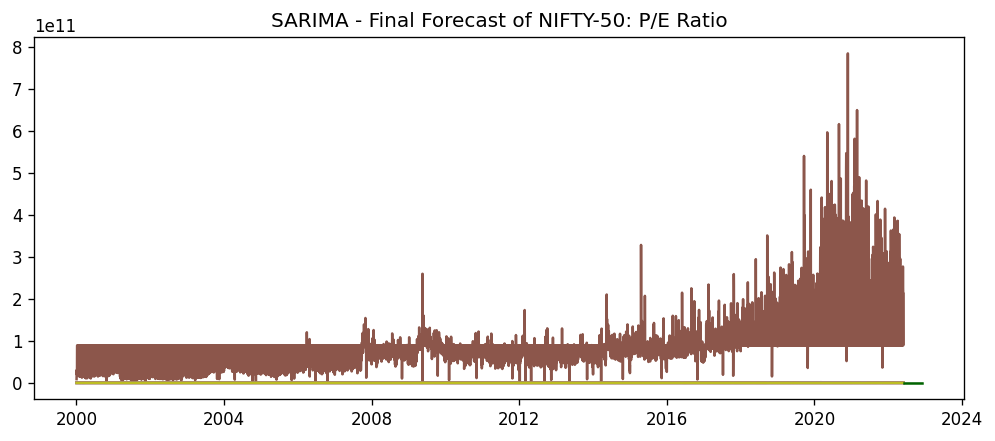

In [22]:
# Forecast
n_periods = 7
fitted, confint = smodel.predict(n_periods=n_periods, return_conf_int=True)
index_of_fc = pd.date_range(data.index[-1], periods = n_periods, freq='MS')

# make series for plotting purpose
fitted_series = pd.Series(fitted, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

# Plot
plt.rcParams.update({'figure.figsize':(10,4), 'figure.dpi':120})

plt.plot(data)
plt.plot(fitted_series, color='darkgreen')
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)

plt.title("SARIMA - Final Forecast of NIFTY-50: P/E Ratio")
plt.show()

In [ ]:
#model = pm.auto_arima(x, seasonal=False, m=12)

In [ ]:
#model.summary()

In [ ]:
#test.loc['2020-05-29']
#test

In [23]:
start = len(y_train)
end = len(y_train) + len(y_test) - 1
predictions = smodel.predict(start, end,
                             typ = 'levels')

In [28]:
y_train['predictions']=predictions

C:\Users\Pawan\AppData\Local\Temp\ipykernel_11320\3172081715.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_train['predictions']=predictions


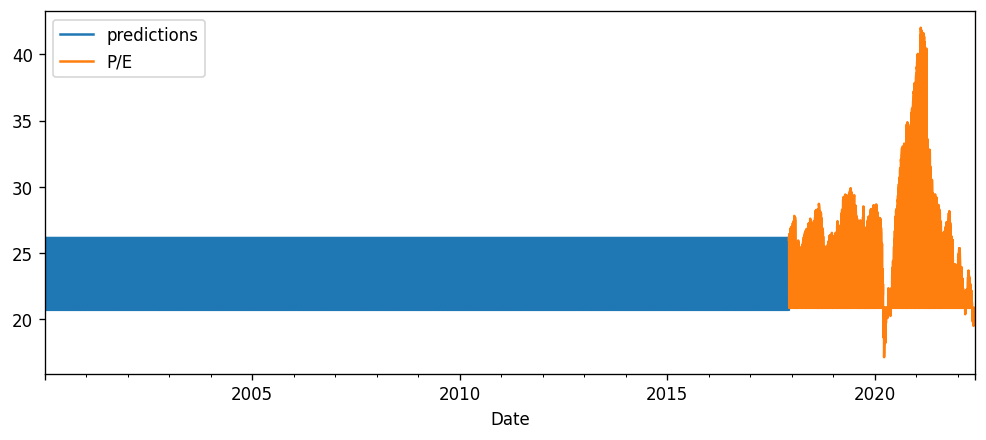

In [26]:
# plot predictions and actual values

y_train['predictions'].plot(legend = True)
y_test['P/E'].plot(legend = True)
plt.show()

# Time Series Forecasting

* Introduction to Time Series Forecasting
* Introduction to ARIMA Models
* What does the p, d and q in ARIMA model mean?
* What are AR and MA models
* How to find the order of differencing (d) in ARIMA model
* How to find the order of the AR term (p)
* How to find the order of the MA term (q)
* How to handle if a time series is slightly under or over differenced
* How to build the ARIMA Model
* How to do find the optimal ARIMA model manually using Out-of-Time Cross validation
* Accuracy Metrics for Time Series Forecast
* How to do Auto Arima Forecast in Python
* How to interpret the residual plots in ARIMA model
* How to automatically build SARIMA model in python
* How to build SARIMAX Model with exogenous variable
* Practice Exercises
* Conclusion

# 1. Time Series Forecasting

A time series is a sequence where a metric is recorded over regular time intervals.

Depending on the frequency, a time series can be of yearly (ex: annual budget), quarterly (ex: expenses), monthly (ex: air traffic), weekly (ex: sales qty), daily (ex: weather), hourly (ex: stocks price), minutes (ex: inbound calls in a call canter) and even seconds wise (ex: web traffic).

forecasting a time series (like demand and sales) is often of tremendous commercial value.

Now forecasting a time series can be broadly divided into two types.

If you use only the previous values of the time series to predict its future values, it is called Univariate Time Series Forecasting.

And if you use predictors other than the series (a.k.a exogenous variables) to forecast it is called Multi Variate Time Series Forecasting.

# 2. ARIMA (Auto Regressive Integrated Moving Average) Models

ARIMA, short for ‘Auto Regressive Integrated Moving Average’ is actually a class of models that ‘explains’ a given time series based on its own past values, that is, its own lags and the lagged forecast errors, so that equation can be used to forecast future values.

##### Parameters of ARIMA and its limitations.

Any ‘non-seasonal’ time series that exhibits patterns and is not a random white noise can be modeled with ARIMA models.

An ARIMA model is characterized by 3 terms: p, d, q

where,

p is the order of the AR term

q is the order of the MA term

d is the number of differencing required to make the time series stationary

If a time series, has seasonal patterns, then you need to add seasonal terms and it becomes **SARIMA**, short for ‘Seasonal ARIMA’. More on that once we finish ARIMA.
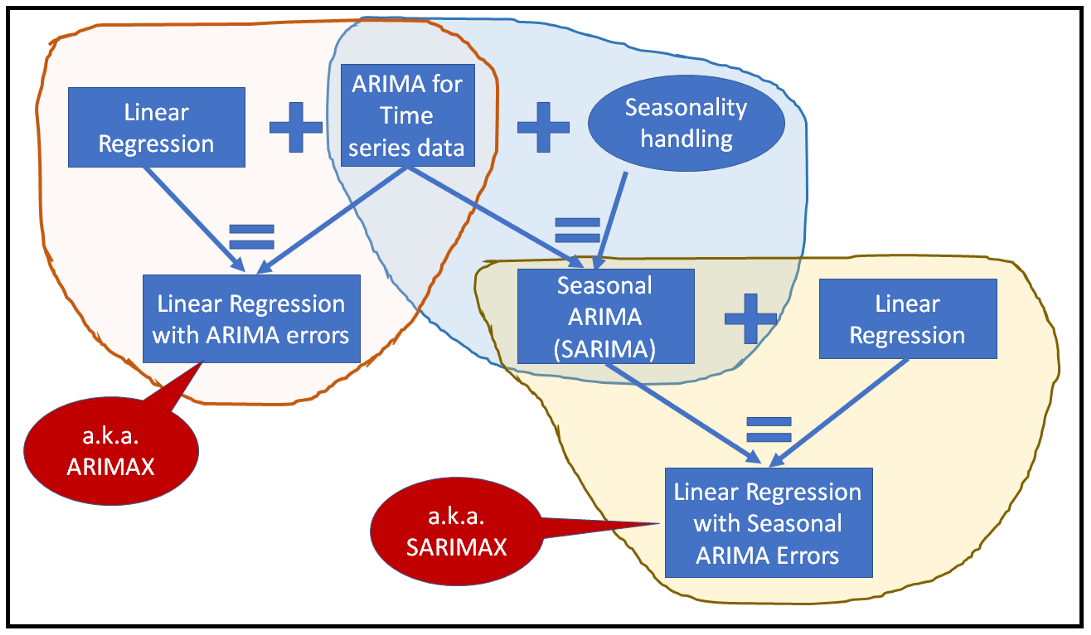

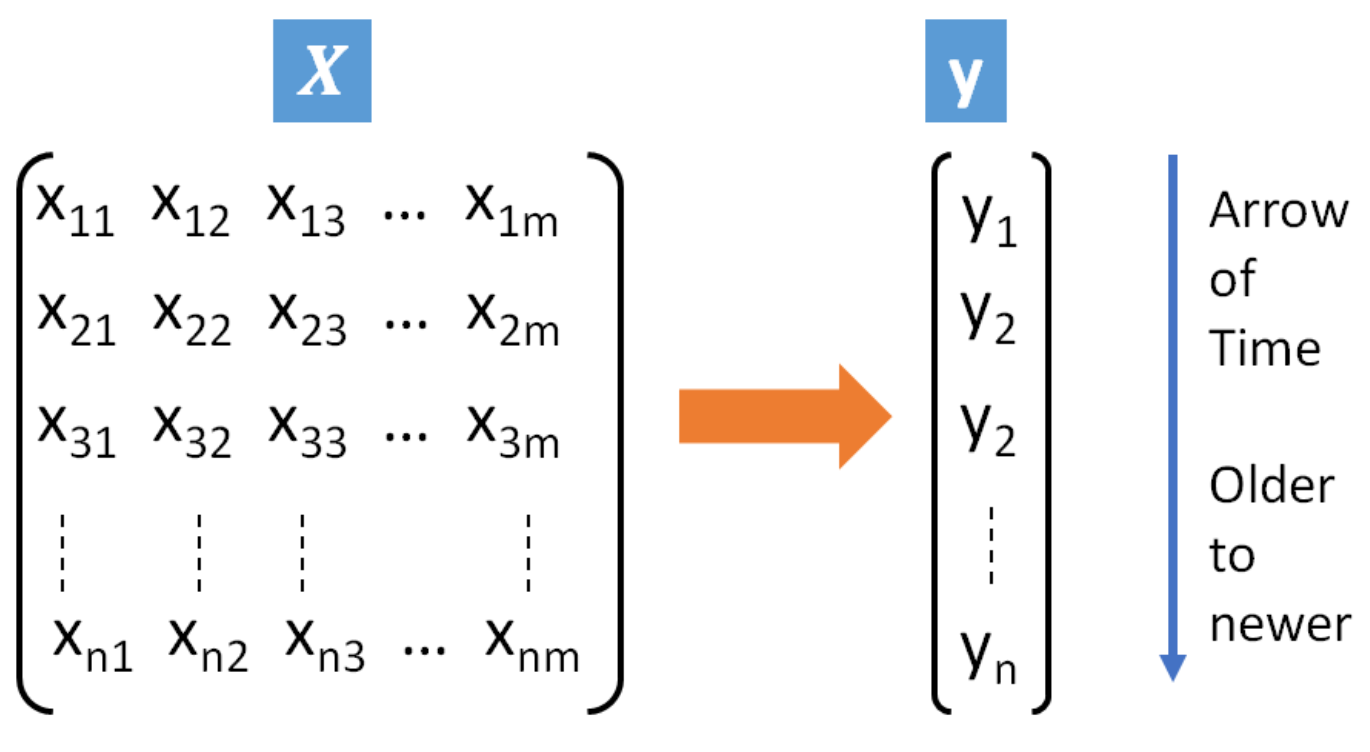

## SRIMAX
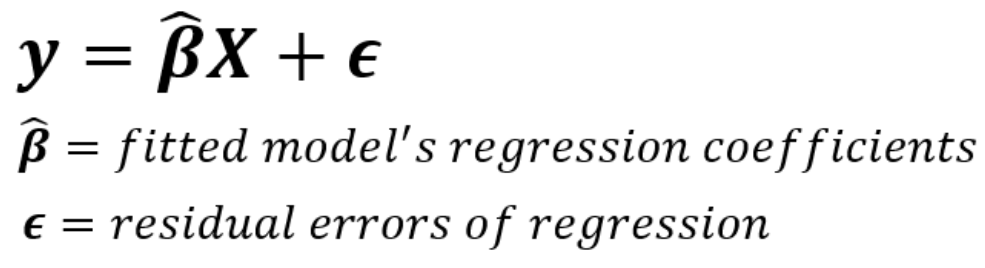

 β(cap) is an (m x 1) size vector storing the fitted model’s regression coefficients.

ε, the residual errors of regression is the difference between the actual y and the value y(cap) predicted by the model. So at each time step i:
ε_i = y_i — y(cap)_i. 
ε is a vector of size (n x 1), assuming a data set spanning n time steps.

# 3. p, d and q in ARIMA model mean

The first step to build an ARIMA model is to make the time series stationary.

Why?

Because, term ‘Auto Regressive’ in ARIMA means it is a linear regression model that uses its own lags as predictors. Linear regression models, as you know, work best when the predictors are not correlated and are independent of each other.

So how to make a series stationary?

The most common approach is to difference it. That is, subtract the previous value from the current value. Sometimes, depending on the complexity of the series, more than one differencing may be needed.

The value of d, therefore, is the minimum number of differencing needed to make the series stationary. And if the time series is already stationary, then d = 0.

Next, what are the ‘p’ and ‘q’ terms?

‘p’ is the order of the ‘Auto Regressive’ (AR) term. It refers to the number of lags of Y to be used as predictors. 

And ‘q’ is the order of the ‘Moving Average’ (MA) term. It refers to the number of lagged forecast errors that should go into the ARIMA Model.


# SARIMA model

* **AR:** The Auto-Regressive (AR) component is a linear combination of past values of the time series up to some number of lags p. i.e. y_i is a linear combination of y_(i-1), y_(i-2),…y_(i-p) as follows:

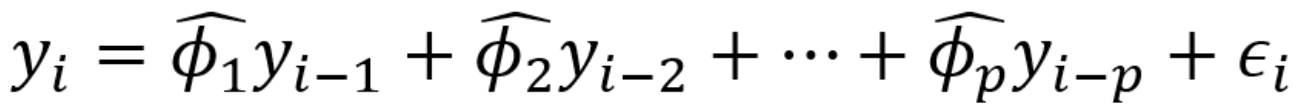

y_i is the actual value observed at the ith time step. The phi(cap)_i are the fitted model’s regression coefficients. The ε_i is the residual error of regression for the ith time step. The order ‘p’ of the AR(p) model is determined using a combination of well-known rules and modeler’s judgement.


* **MA:** The Moving Average (MA) component of SARIMA is a linear combination of the model’s past errors up to some number of lags q. The model’s past errors are calculated by subtracting the past predictions from past actual values. The MA(q) model is expressed as follows:

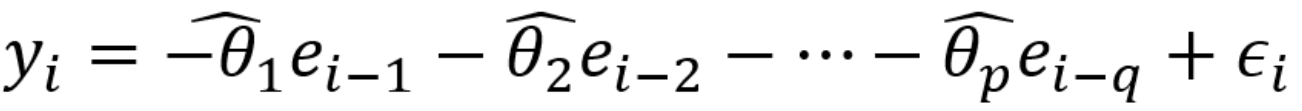

y_i is the actual value observed at the ith time step. The theta(cap)_i are the fitted model’s regression coefficients. The ε_i is the residual error of regression for the ith time step. The negative signs are as per the convention for specifying MA models. The order ‘q’ of the MA(q) model is determined using a combination of well-known rules and the modeler’s judgement.


### The combined ARMA (p,q) model is simply the combination of the AR(p) and MA(q) models:
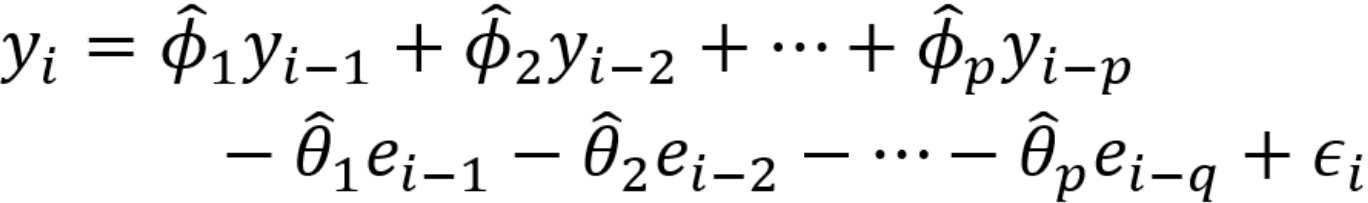

* **Order of differencing (d):** The ARMA model cannot be used if the time series has a trend. Common examples of trend are linear trend, quadratic trend and exponential or logarithmic trends. If the time series demonstrates a trend, one applies one or more orders of differencing to the time series so as to remove the trend. A first order difference will remove a linear trend of the type y = m*x + x. Second and higher order differences will remove polynomial trends of the kind y = m*x² + c, y = x*x³ + c etc.

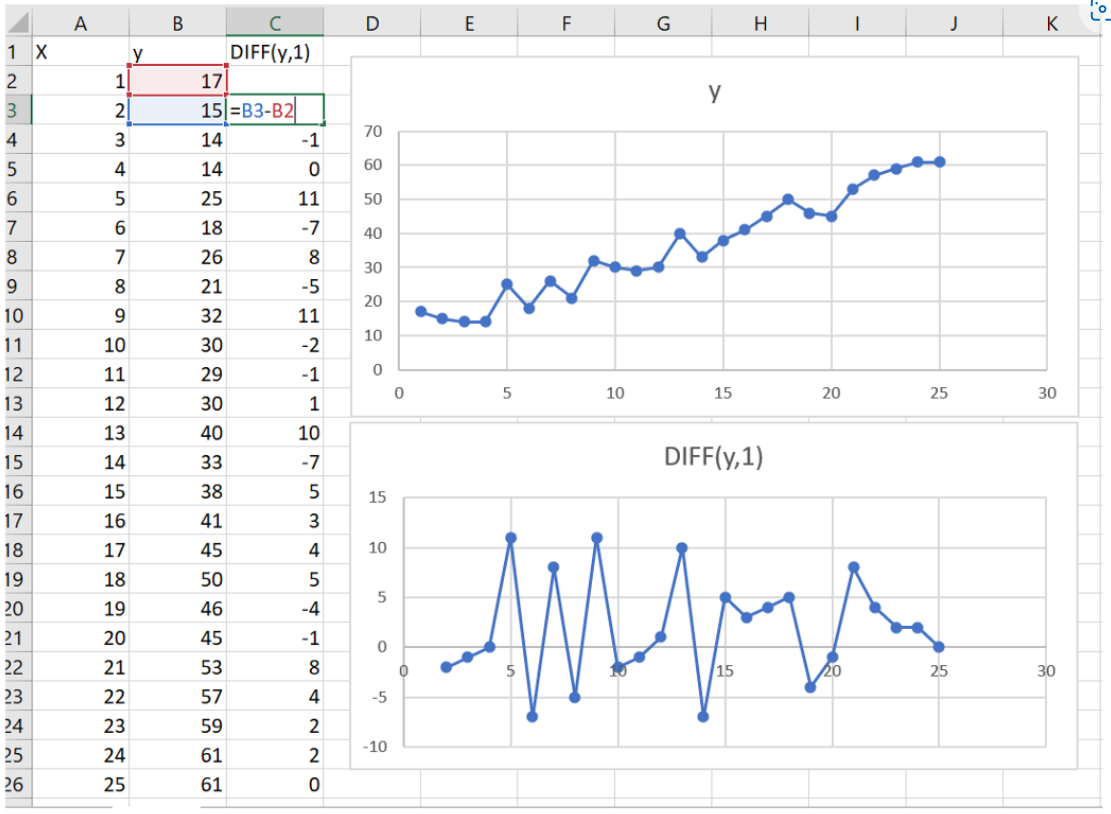

The difference operation in ARIMA models is denoted by the I letter. In ARIMA, I stands for Integrated. Differencing is applied by ARIMA models before the AR and the MA terms are brought into play. The order of differencing is denoted by the d parameter in the ARIMA(p,d,q) model specification.

* **SAR, SMA, D and m:** The Seasonal ARIMA or SARIMA model simply extends the above concepts concepts of AR, MA and differencing to the seasonal realm by introducing a Seasonal AR (SAR) term of order P, Seasonal MA (SMA) term of order Q, and a Seasonal Difference of order D. The final parameter in SARIMA models is ‘m’ which is the seasonal period. For e.g. m=12 months for a time series that exhibits yearly seasonality. Just as with p,d and q, there are well established rules for estimating the values of P, D, Q and m.

# Regression with Seasonal ARIMA Errors (SRIMAX)

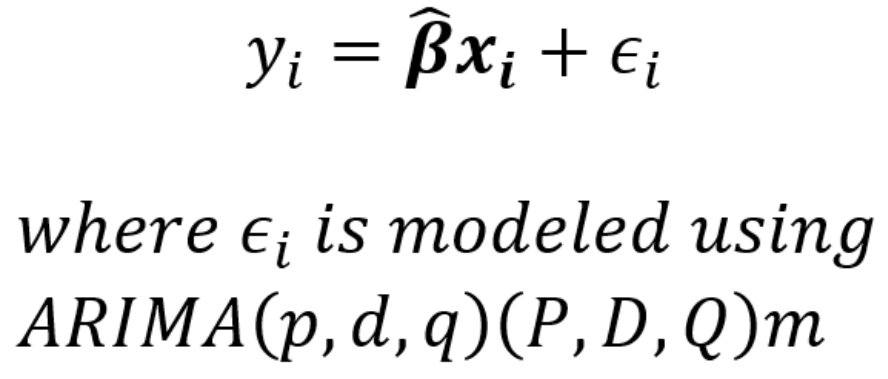

In [29]:
import pandas as pd
from statsmodels.regression import linear_model
from patsy import dmatrices
import statsmodels.graphics.tsaplots as tsa
from matplotlib import pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA as ARIMA
import numpy as np

In [30]:
data= pd.read_excel('AirQualityUCI/AirQualityUCI.xlsx', parse_dates=[['Date', 'Time']])
data.head()

Date_Time  CO(GT)  PT08.S1(CO)  NMHC(GT)   C6H6(GT)  \
0 2004-03-10 18:00:00     2.6      1360.00       150  11.881723   
1 2004-03-10 19:00:00     2.0      1292.25       112   9.397165   
2 2004-03-10 20:00:00     2.2      1402.00        88   8.997817   
3 2004-03-10 21:00:00     2.2      1375.50        80   9.228796   
4 2004-03-10 22:00:00     1.6      1272.25        51   6.518224   

   PT08.S2(NMHC)  NOx(GT)  PT08.S3(NOx)  NO2(GT)  PT08.S4(NO2)  PT08.S5(O3)  \
0        1045.50    166.0       1056.25    113.0       1692.00      1267.50   
1         954.75    103.0       1173.75     92.0       1558.75       972.25   
2         939.25    131.0       1140.00    114.0       1554.50      1074.00   
3         948.25    172.0       1092.00    122.0       1583.75      1203.25   
4         835.50    131.0       1205.00    116.0       1490.00      1110.00   

       T         RH        AH  
0  13.60  48.875001  0.757754  
1  13.30  47.700000  0.725487  
2  11.90  53.975000  0.750239  
3  11.00  60.000000  0.786713  
4  11.15  59.575001  0.788794

### Build a regression model to predict the hourly value of the PT08_S4_NO2 variable.

In [31]:
data.shape

(9357, 14)

In [32]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9357 entries, 0 to 9356
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Date_Time      9357 non-null   datetime64[ns]
 1   CO(GT)         9357 non-null   float64       
 2   PT08.S1(CO)    9357 non-null   float64       
 3   NMHC(GT)       9357 non-null   int64         
 4   C6H6(GT)       9357 non-null   float64       
 5   PT08.S2(NMHC)  9357 non-null   float64       
 6   NOx(GT)        9357 non-null   float64       
 7   PT08.S3(NOx)   9357 non-null   float64       
 8   NO2(GT)        9357 non-null   float64       
 9   PT08.S4(NO2)   9357 non-null   float64       
 10  PT08.S5(O3)    9357 non-null   float64       
 11  T              9357 non-null   float64       
 12  RH             9357 non-null   float64       
 13  AH             9357 non-null   float64       
dtypes: datetime64[ns](1), float64(12), int64(1)
memory usage: 1023.5 KB


In [33]:
data.rename(columns = {'PT08.S4(NO2)':'PT08_S4_NO2'}, inplace = True)

In [34]:
data.corr()['PT08_S4_NO2']

CO(GT)          -0.073721
PT08.S1(CO)      0.845133
NMHC(GT)         0.162689
C6H6(GT)         0.774649
PT08.S2(NMHC)    0.874761
NOx(GT)          0.035580
PT08.S3(NOx)     0.122672
NO2(GT)         -0.022092
PT08_S4_NO2      1.000000
PT08.S5(O3)      0.723670
T                0.755053
RH               0.640685
AH               0.691889
Name: PT08_S4_NO2, dtype: float64

The matrix of regression variables X will contain two variables:
* Temperature T
* Absolute Humidity AH

### STEP 1: Prepare the data

In [35]:
type(data['Date_Time'])

pandas.core.series.Series

In [36]:
data['DateTimeIndex']= pd.to_datetime(data['Date_Time'])
data = data.set_index(keys=['DateTimeIndex'])

Set the frequency attribute of the index to Hourly. This will create several empty rows corresponding to the missing hourly measurements in the original data set. Fill up all the empty data cells with the mean of the corresponding column.

In [37]:
data = data.asfreq('H')
data = data.fillna(data.mean(numeric_only=True))
data.shape

(9357, 14)

In [38]:
data.isin([np.nan, np.inf, -np.inf]).sum()

Date_Time        0
CO(GT)           0
PT08.S1(CO)      0
NMHC(GT)         0
C6H6(GT)         0
PT08.S2(NMHC)    0
NOx(GT)          0
PT08.S3(NOx)     0
NO2(GT)          0
PT08_S4_NO2      0
PT08.S5(O3)      0
T                0
RH               0
AH               0
dtype: int64

In [39]:
dataset_len = len(data)
split_index = round(dataset_len*0.9)
train_set_end_date = data.index[split_index]

In [40]:
data.columns

Index(['Date_Time', 'CO(GT)', 'PT08.S1(CO)', 'NMHC(GT)', 'C6H6(GT)',
       'PT08.S2(NMHC)', 'NOx(GT)', 'PT08.S3(NOx)', 'NO2(GT)', 'PT08_S4_NO2',
       'PT08.S5(O3)', 'T', 'RH', 'AH'],
      dtype='object')

In [41]:
df_train = data.loc[data.index <= train_set_end_date].copy()
df_test = data.loc[data.index > train_set_end_date].copy()

In [42]:
df_train.columns

Index(['Date_Time', 'CO(GT)', 'PT08.S1(CO)', 'NMHC(GT)', 'C6H6(GT)',
       'PT08.S2(NMHC)', 'NOx(GT)', 'PT08.S3(NOx)', 'NO2(GT)', 'PT08_S4_NO2',
       'PT08.S5(O3)', 'T', 'RH', 'AH'],
      dtype='object')

### STEP 2: Create a Linear Regression model

In [43]:
expr = 'PT08_S4_NO2 ~ T + AH'

In [44]:
y_train, X_train = dmatrices(expr, df_train, return_type='dataframe')
y_test, X_test = dmatrices(expr, df_test, return_type='dataframe')

### Ordinary Least Squares Linear Regression model

In [45]:
olsr_results = linear_model.OLS(y_train, X_train).fit()

In [46]:
olsr_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            PT08_S4_NO2   R-squared:                       0.654
Model:                            OLS   Adj. R-squared:                  0.654
Method:                 Least Squares   F-statistic:                     7969.
Date:                Tue, 31 May 2022   Prob (F-statistic):               0.00
Time:                        16:38:52   Log-Likelihood:                -59426.
No. Observations:                8422   AIC:                         1.189e+05
Df Residuals:                    8419   BIC:                         1.189e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1113.6844      7.218    154.302      0.000    1099.536    1127.833
T             20.5513      0.365     56.237      0.000      19.835      21.268
AH           -13.9624      0.405    -34.444      0.000     -14.757     -13.168
==============================================================================
Omnibus:                      904.777   Durbin-Watson:                   0.286
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1410.196
Skew:                           0.785   Prob(JB):                    6.02e-307
Kurtosis:                       4.247   Cond. No.                         144.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

We see that the regression coefficients of both regression variables T and AH are significant at a 99.99% confidence level as indicated by their P values (P > |t| column) which are essentially 0.

The second thing to note in these results is the output of the Durbin-Watson test which measures the degree of LAG-1 auto-correlation in the residual errors of regression. A value of 2 implies no LAG-1 auto-correlation. A value closer to 0 implies strong positive auto-correlation while a value close to 4 implies a strong negative auto-correlation at LAG-1 among the residuals errors ε.

In the above output, we see that the DW test statistic is 0.28 indicating a strong positive auto-correlation among the residual errors of regression at LAG-1. This was completely expected since the underlying data is a time series and the linear regression model has failed to explain the auto-correlation in the dependent variable. The DW test statistic just confirms it.

### STEP 3: Estimate (S)ARIMA parameters (p,d,q), (P,D,Q) and m

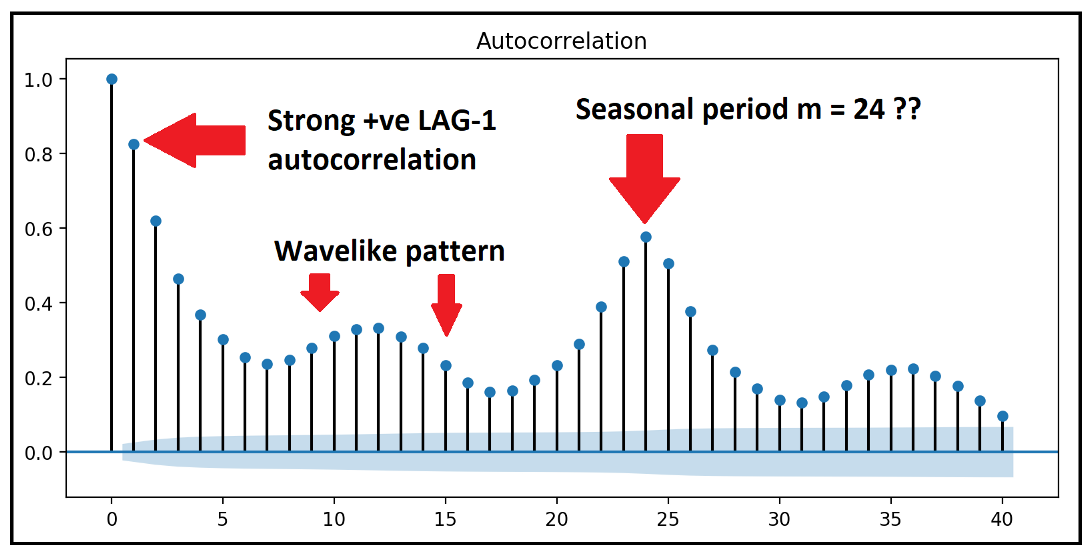

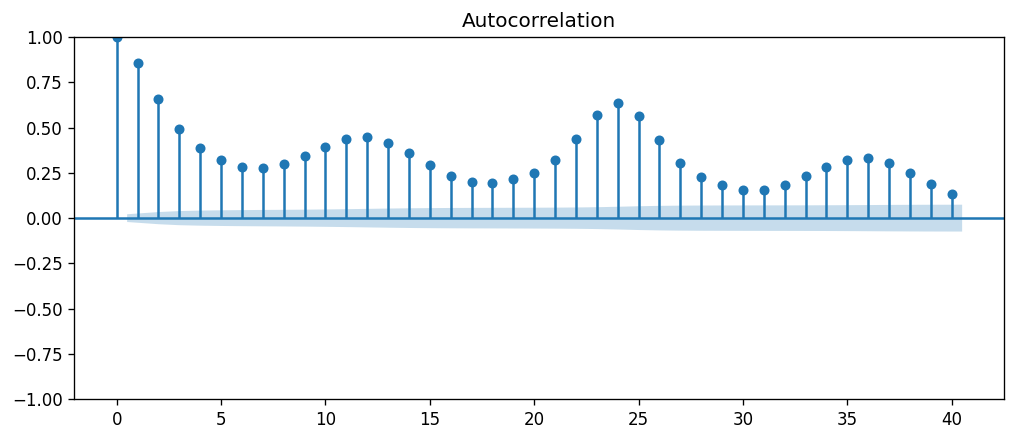

In [47]:
tsa.plot_acf(olsr_results.resid, alpha=0.05)
plt.show()

The ACF tells us three things:

* There are strong auto-correlations extending out to multiple lags indicating that the residual errors time series has a trend. We’ll need to de-trend this time series by using one or possibly 2 orders of differencing. Thus, the parameter d is likely to be 1, or possibly 2.
* The wavelike pattern in the ACF evidences a seasonal variation in the data.
* The peak at LAG = 24 indicates that the seasonal period is likely to be 24 hours. i.e. m is likely to be 24. This seems reasonable for data containing vehicular pollution measurements. We’ll soon verify this guess using the time series decomposition plot.

### Before we estimate the rest of the (S)ARIMA parameters, let’s difference the time series once i.e. d=1:

In [48]:
olsr_results.resid.head()

DateTimeIndex
2004-03-10 18:00:00    309.398174
2004-03-10 19:00:00    181.863043
2004-03-10 20:00:00    206.730434
2004-03-10 21:00:00    254.985851
2004-03-10 22:00:00    158.182221
dtype: float64

In [49]:
olsr_resid_diff_1 = olsr_results.resid.diff()
olsr_resid_diff_1.head()

DateTimeIndex
2004-03-10 18:00:00           NaN
2004-03-10 19:00:00   -127.535131
2004-03-10 20:00:00     24.867390
2004-03-10 21:00:00     48.255417
2004-03-10 22:00:00    -96.803629
dtype: float64

In [50]:
olsr_resid_diff_1.isnull().sum()

1

In [51]:
olsr_resid_diff_1 = olsr_resid_diff_1.dropna()

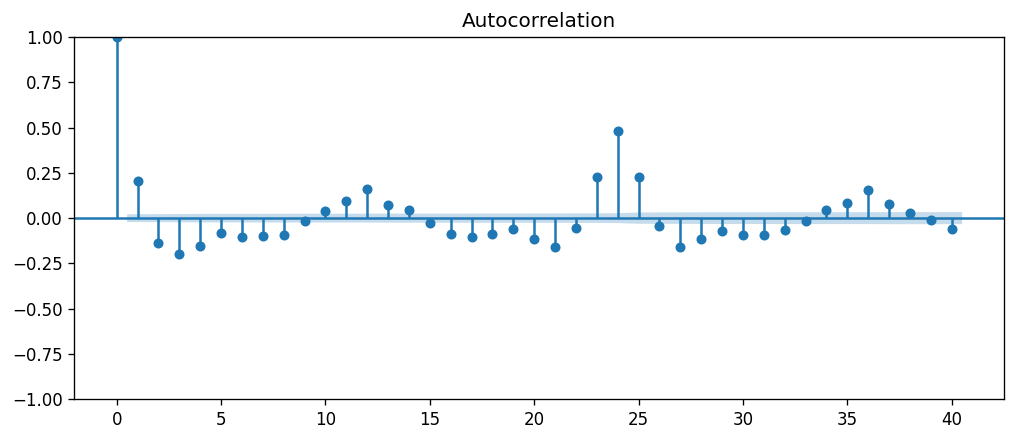

In [52]:
tsa.plot_acf(olsr_resid_diff_1, alpha=0.05)
plt.show()

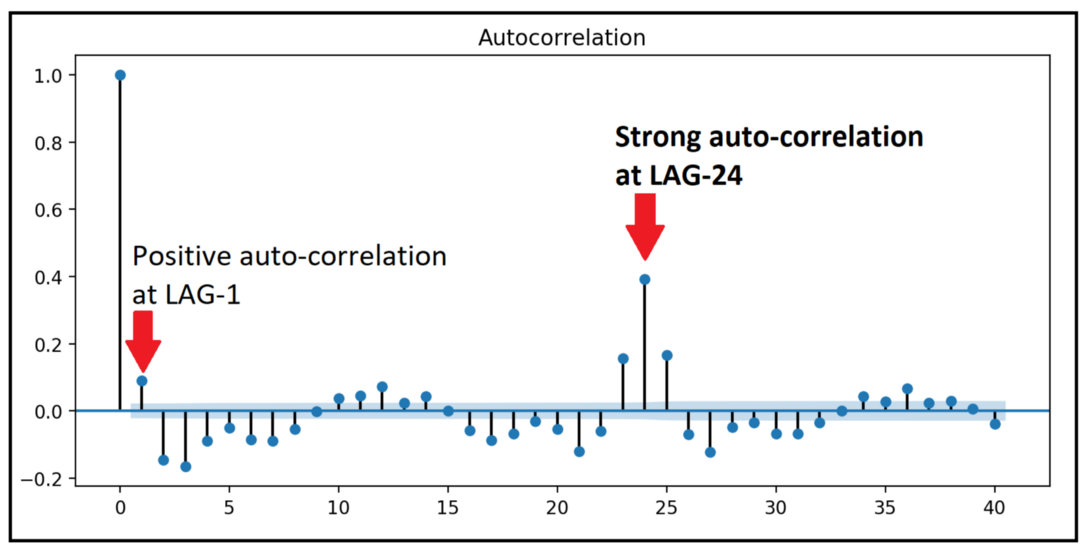

We now see a very different picture in the ACF. The auto-correlations are significantly reduced at all lags. The wavelike pattern still exists but that’s because we did nothing to remove the possible seasonal variation. The LAG-24 auto-correlation is once again especially prominent.

We see that there is still a significant auto-correlation at LAG-1 in the differenced time series. We could try extinguishing it by taking one more difference, i.e. d=2 and plotting the resulting time series’ ACF:

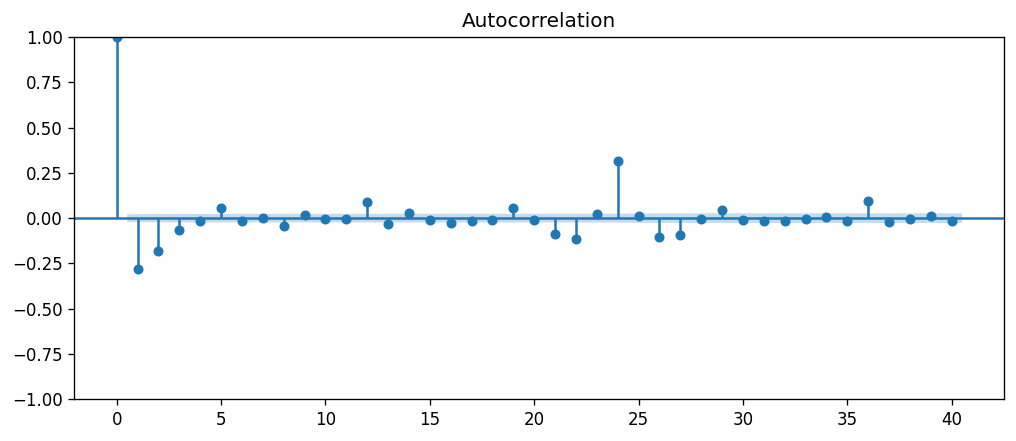

In [53]:
olsr_resid_diff_2 = olsr_resid_diff_1.diff()
olsr_resid_diff_2 = olsr_resid_diff_2.dropna()
tsa.plot_acf(olsr_resid_diff_2, alpha=0.05)
plt.show()

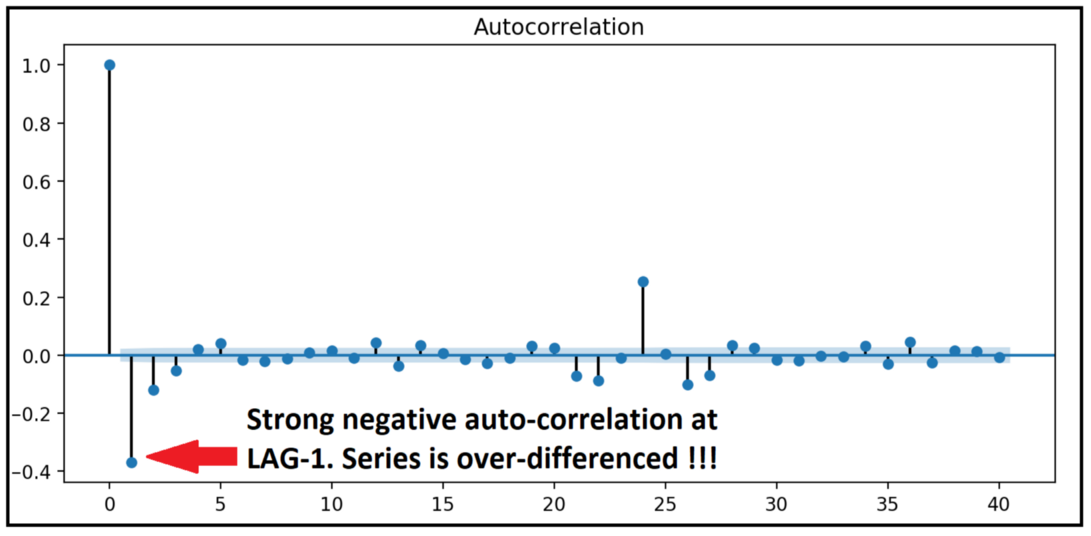

Unfortunately, diff-ing the time series a second time has produced a heavy negative auto-correlation at LAG-1. This is bad sign. We seem to have over-done the differencing. We should stick with d=1.

The single positive auto-correlation at LAG-1 indicates that we may want to fix the AR order p to 1. i.e. an AR(1) model.

Since we have fixed p to 1, for now, we’ll leave out the MA portion of the model. i.e. we fix q to 0. i.e. our SARIMA model will not have an MA component.

So far we have the following: p=1, d=1, q=0


Let’s verify that the seasonal period m is 24 hours. To do that, we’ll decompose the residual errors of regression into trend, seasonality and noise by using the seasonal_decompose() function provided by statsmodels:

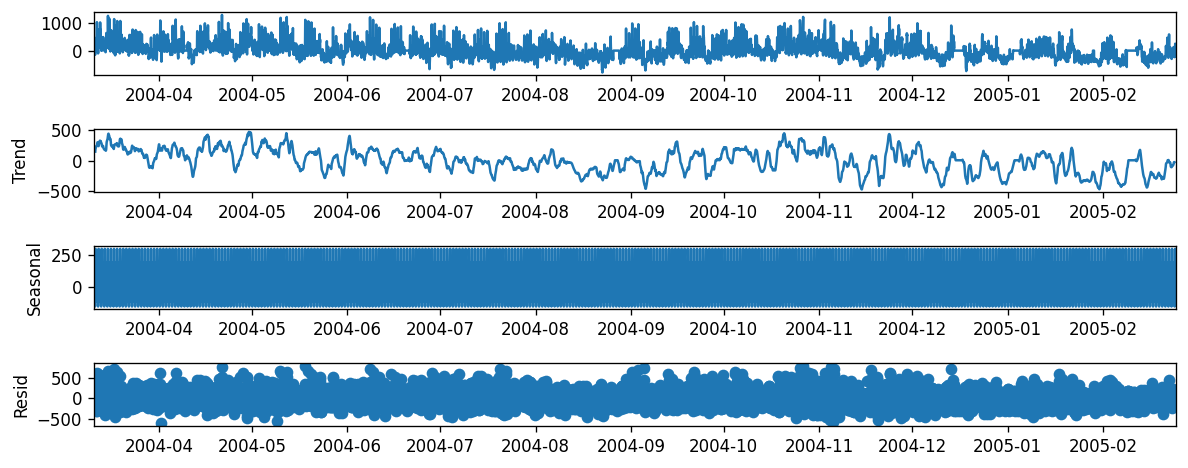

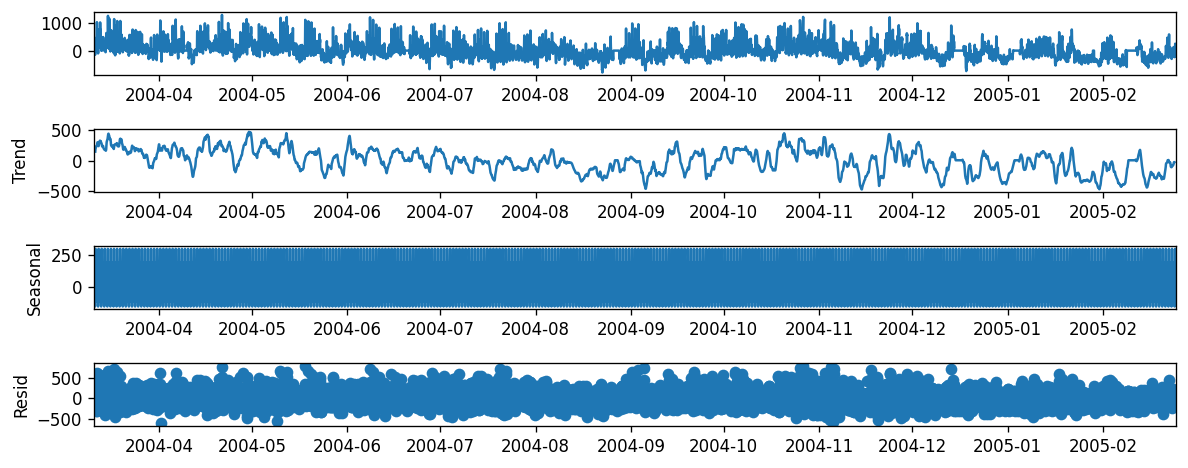

In [54]:
components = seasonal_decompose(olsr_results.resid)
components.plot()

The seasonal component confirms that m=24.

The strong seasonal component warrants a single seasonal order of differencing, i.e. we set D=1.

Let’s apply a single seasonal difference to our already differenced time series of residual errors:

In [55]:
olsr_resid_diff_1_24 = olsr_resid_diff_1.diff(periods=24)

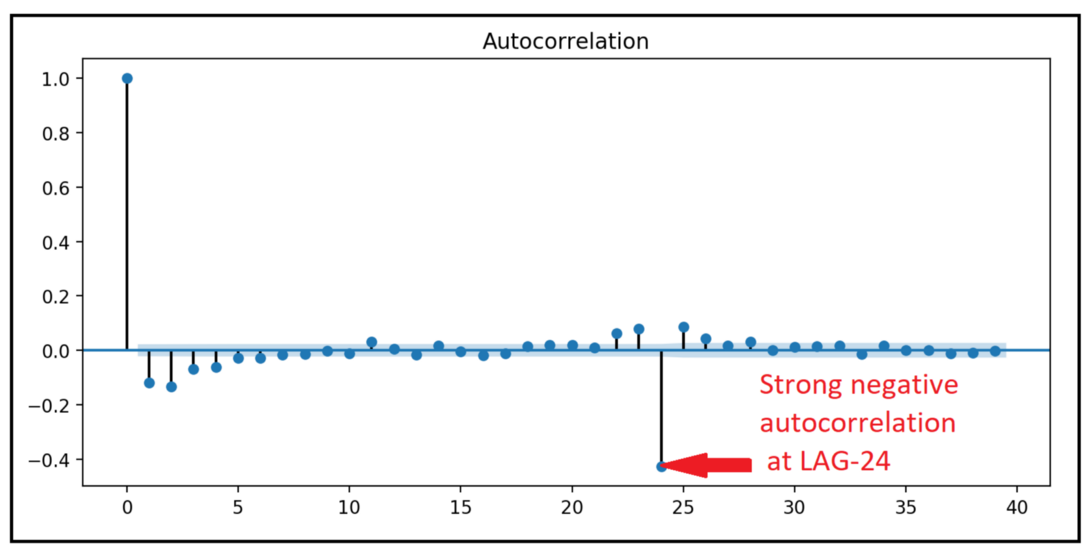

The strong negative correlation at LAG-24 indicates a Seasonal MA (SMA) signature with order 1. i.e. Q=1. Moreover, an absence of positive correlation at LAG-1, indicates an absence of a Seasonal AR component. i.e. P=0.

We have fixed P=0, D=1 and Q=1, and m=24 hours

That’s it.

We have managed to estimate all 7 params of the SARIMA model as follows:
p=1, d=1, q=0, P=0, D=1, Q=1 and m=24 i.e. SARIMAX(1,1,0)(0,1,1)24

# STEP 4: Build and fit the Regression Model with Seasonal ARIMA errors

Let’s fit the SARIMAX model on the training data set (y_train, X_train) using the above parameters. Before we do that, we need to remove the intercept that Patsy had auto-added to X_train and reset the time series index frequency to Hourly on both X_train and y_train.

In [56]:
X_train_minus_intercept = X_train.drop('Intercept', axis=1)
X_train_minus_intercept = X_train_minus_intercept.asfreq('H')

In [57]:
y_train = y_train.asfreq('H')

In [58]:
from statsmodels.tsa.arima.model import ARIMA
sarimax_model = ARIMA(endog=y_train,  exog=X_train_minus_intercept, 
                                                  order=(1,1,0), 
                                                  seasonal_order=(0,1,1,24))

In [59]:
sarimax_results = sarimax_model.fit()

In [60]:
sarimax_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                        PT08_S4_NO2   No. Observations:                 8422
Model:             ARIMA(1, 1, 0)x(0, 1, [1], 24)   Log Likelihood              -51815.958
Date:                            Tue, 31 May 2022   AIC                         103641.916
Time:                                    16:39:50   BIC                         103677.094
Sample:                                03-10-2004   HQIC                        103653.928
                                     - 02-24-2005                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
T             -4.6351      0.628     -7.383      0.000      -5.865      -3.405
AH            13.3304      0.673     19.808      0.000      12.011      14.649
ar.L1         -0.0041      0.008     -0.519      0.604      -0.020       0.011
ma.S.L24      -0.9184      0.003   -281.217      0.000      -0.925      -0.912
sigma2      1.334e+04    124.277    107.318      0.000    1.31e+04    1.36e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):              5180.05
Prob(Q):                              0.93   Prob(JB):                         0.00
Heteroskedasticity (H):               0.66   Skew:                            -0.10
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.84
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

The number to look at first in the training summary is the Ljung-Box test’s statistic and its p-value. The Ljung-Box helps us determine if the residual errors of regression are auto-correlated in a statistically significant way. In this case, the p value is 0.93 which is significantly higher than 0.05 (95% confidence threshold). So we accept the Null hypothesis of the Ljung-Box test that the residual errors are not auto-correlated.

Two other things to note in the result: The Jarque-Bera test of normality has yielded a vanishingly small p-value implying a rejection of the Null hypothesis at a > 99.99% confidence level. The Null hypothesis being that the regression errors are normally distributed. This is probably because the errors are highly kurtotic (note that the Kurtosis=6.84 as against the 3.0 that it should have been for a normal distribution). Note also that the errors are not at all skewed (skewness=-0.10 as against 0.0 for normally distributed errors).

The regression errors are also heteroskedastic i.e. they have non-constant variance. This is evidenced by the vanishingly small p-value of the H-test, but there are some things you can do to fix that.

We could also experiment with a different combination of parameters for p,d,q,P,D,Q and m. It turns out, this sort of an iteration with different SARIMAX models is not unusual in the SARIMAX world.

What we’ll do is to simplify our model by setting Q to 0. i.e. we’ll try a SARIMAX(1,1,0)(0,1,0)24 model:

In [61]:
sarimax_model = ARIMA(endog=y_train, exog=X_train_minus_intercept,order=(1,1,0), seasonal_order=(0,1,0,24))
sarimax_results = sarimax_model.fit()
sarimax_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                    SARIMAX Results                                     
========================================================================================
Dep. Variable:                      PT08_S4_NO2   No. Observations:                 8422
Model:             ARIMA(1, 1, 0)x(0, 1, 0, 24)   Log Likelihood              -53887.658
Date:                          Tue, 31 May 2022   AIC                         107783.315
Time:                                  16:39:53   BIC                         107811.458
Sample:                              03-10-2004   HQIC                        107792.925
                                   - 02-24-2005                                         
Covariance Type:                            opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
T             -4.9003      0.688     -7.123      0.000      -6.249      -3.552
AH            13.6175      0.738     18.442      0.000      12.170      15.065
ar.L1         -0.0519      0.008     -6.482      0.000      -0.068      -0.036
sigma2      2.195e+04    208.195    105.422      0.000    2.15e+04    2.24e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.67   Jarque-Bera (JB):              4288.52
Prob(Q):                              0.41   Prob(JB):                         0.00
Heteroskedasticity (H):               0.69   Skew:                             0.06
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.50
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In this revised model, we see that the p-value of Ljung-Box test statistic has reduced from the earlier value of 0.93 to 0.4 implying that the regression errors of this model are much less likely to be non-correlated than in the earlier model. The new model does not seem to have made the errors any less heteroskedastic or more normally distributed than the previous model.

We’ll accept earlier version of the model, namely SARIMAX(1,1,0)(0,1,1)24 model.

### STEP 5: Prediction

The final step in our SARIMAX saga is using the chosen model to generate some predictions. We’ll ask the model to generate 24 out-of-sample predictions i.e. predict the value of the y (pollutant PT08_S4_NO2) for the next 24 hours beyond the end of the training data set. We’ll use the testing data set (y_test, X_test) which we had carved out in STEP-1. Recollect that the model has never seen the test data set during training.

Let’s prepare the test data set for prediction:

In [62]:
X_test_minus_intercept = X_test.drop('Intercept', axis=1)
X_test_minus_intercept = X_test_minus_intercept.asfreq('H')
y_test = y_test.asfreq('H')

In [63]:
predictions = sarimax_results.get_forecast(steps=24, exog=X_test_minus_intercept[:24])
predictions.summary_frame()

PT08_S4_NO2                 mean     mean_se  mean_ci_lower  mean_ci_upper
2005-02-24 16:00:00  1286.066400  148.149772     995.698183    1576.434617
2005-02-24 17:00:00  1308.454485  204.153164     908.321635    1708.587335
2005-02-24 18:00:00  1345.693115  248.033957     859.555492    1831.830738
2005-02-24 19:00:00  1376.087728  285.232092     817.043100    1935.132356
2005-02-24 20:00:00  1388.823150  318.110281     765.338456    2012.307845
2005-02-24 21:00:00  1321.101818  347.895013     639.240122    2002.963514
2005-02-24 22:00:00  1272.220103  375.323500     536.599560    2007.840647
2005-02-24 23:00:00  1113.467027  400.879682     327.757288    1899.176767
2005-02-25 00:00:00  1107.524003  424.901529     274.732309    1940.315697
2005-02-25 01:00:00  1049.398851  447.636124     172.048170    1926.749532
2005-02-25 02:00:00  1084.475116  469.270593     164.721656    2004.228577
2005-02-25 03:00:00  1026.018596  489.950690      65.732888    1986.304303
2005-02-25 04:00:00  1015.968915  509.792574      16.793830    2015.144000
2005-02-25 05:00:00  1020.040208  528.890592     -16.566304    2056.646721
2005-02-25 06:00:00  1108.815000  547.322618      36.082381    2181.547620
2005-02-25 07:00:00  1204.677091  565.153818      96.995962    2312.358220
2005-02-25 08:00:00  1458.339739  582.439377     316.779537    2599.899941
2005-02-25 09:00:00  1493.647792  599.226516     319.185402    2668.110182
2005-02-25 10:00:00  1274.075894  615.556015      67.608275    2480.543514
2005-02-25 11:00:00  1176.752969  631.463378     -60.892509    2414.398447
2005-02-25 12:00:00  1143.327287  646.979742    -124.729707    2411.384281
2005-02-25 13:00:00  1248.243590  662.132598     -49.512455    2545.999634
2005-02-25 14:00:00  1268.904163  676.946354     -57.886311    2595.694638
2005-02-25 15:00:00  1342.392606  691.442808     -12.810395    2697.595607

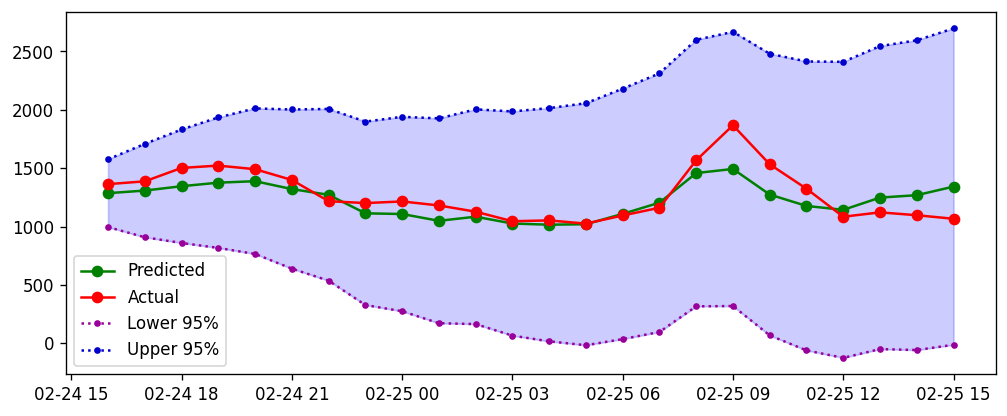

In [64]:
predicted, = plt.plot(X_test_minus_intercept[:24].index, predictions.summary_frame()['mean'], 'go-', label='Predicted')

actual,  = plt.plot( y_test[:24], 'ro-', label='Actual')
 
lower, = plt.plot(X_test_minus_intercept[:24].index, predictions.summary_frame()['mean_ci_lower'], color='#990099', marker='.', linestyle=':', label='Lower 95%')
 
upper, = plt.plot(X_test_minus_intercept[:24].index, predictions.summary_frame()['mean_ci_upper'], color='#0000cc', marker='.', linestyle=':', label='Upper 95%')
 
plt.fill_between(X_test_minus_intercept[:24].index, predictions.summary_frame()['mean_ci_lower'], predictions.summary_frame()['mean_ci_upper'], color = 'b', alpha = 0.2)
plt.legend(handles=[predicted, actual, lower, upper])
plt.show()

# 4. AR and MA models

What are AR and MA models? what is the actual mathematical formula for the AR and MA models?

A pure Auto Regressive (AR only) model is one where Yt depends only on its own lags. That is, Yt is a function of the ‘lags of Yt’.

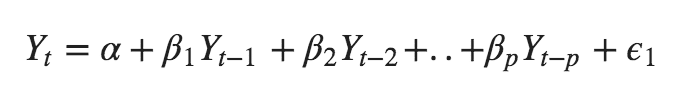


where,
* $Y{t-1}$ is the lag1 of the series, 
* $\beta1$ is the coefficient of lag1 that the model estimates 
* $\alpha$ is the intercept term, also estimated by the model.


Likewise a pure Moving Average (MA only) model is one where Yt depends only on the lagged forecast errors.

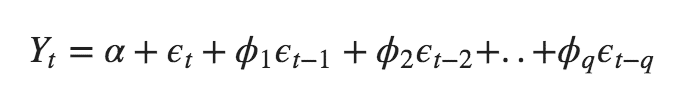

where the error terms are the errors of the autoregressive models of the respective lags. The errors Et and E(t-1) are the errors from the following equations :

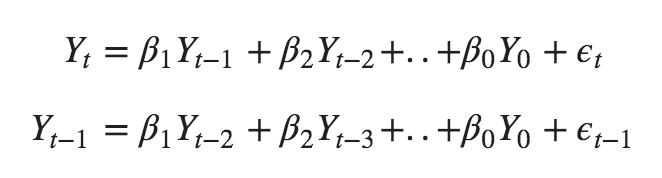

[Error: The beta coefficients in the second equation above is incorrect. ]
That was AR and MA models respectively.

So what does the equation of an ARIMA model look like?

An ARIMA model is one where the time series was differenced at least once to make it stationary and you combine the AR and the MA terms. So the equation becomes:

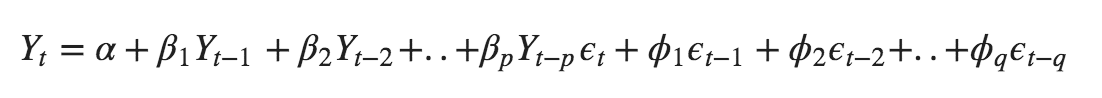

### ARIMA model in words:

Predicted Yt = Constant + Linear combination Lags of Y (upto p lags) + Linear Combination of Lagged forecast errors (upto q lags)

The objective, therefore, is to identify the values of p, d and q. But how?

# 5. How to find the order of differencing (d) in ARIMA model

The purpose of differencing it to make the time series stationary.

But you need to be careful to not over-difference the series. Because, an over differenced series may still be stationary, which in turn will affect the model parameters.

So how to determine the right order of differencing?

The right order of differencing is the minimum differencing required to get a near-stationary series which roams around a defined mean and the ACF plot reaches to zero fairly quick.

If the autocorrelations are positive for many number of lags (10 or more), then the series needs further differencing. On the other hand, if the lag 1 autocorrelation itself is too negative, then the series is probably over-differenced.

In the event, you can’t really decide between two orders of differencing, then go with the order that gives the least standard deviation in the differenced series.

Let’s see how to do it with an example.

First, I am going to check if the series is stationary using the Augmented Dickey Fuller test (adfuller()), from the statsmodels package.

Why?

Because, you need differencing only if the series is non-stationary. Else, no differencing is needed, that is, d=0.

The null hypothesis of the ADF test is that the time series is non-stationary. So, if the p-value of the test is less than the significance level (0.05) then you reject the null hypothesis and infer that the time series is indeed stationary.

So, in our case, if P Value > 0.05 we go ahead with finding the order of differencing.

In [67]:
from statsmodels.tsa.stattools import adfuller
from numpy import log
result = adfuller(df[['P/E']].dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -2.979734
p-value: 0.036831


Since P-value is greater than the significance level, let’s difference the series and see how the autocorrelation plot looks like.

Order of Differencing
For the above series, the time series reaches stationarity with two orders of differencing. But on looking at the autocorrelation plot for the 2nd differencing the lag goes into the far negative zone fairly quick, which indicates, the series might have been over differenced.

So, I am going to tentatively fix the order of differencing as 1 even though the series is not perfectly stationary (weak stationarity).

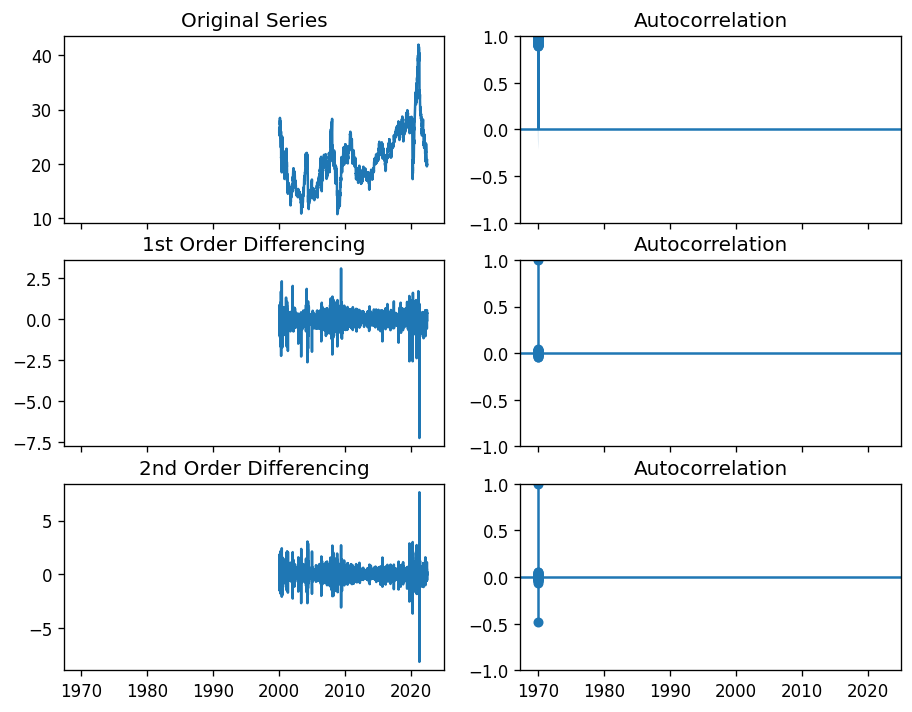

In [69]:
import numpy as np, pandas as pd
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})

# Original Series
fig, axes = plt.subplots(3, 2, sharex=True)
axes[0, 0].plot(df[['P/E']]); axes[0, 0].set_title('Original Series')
plot_acf(df[['P/E']], ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(df[['P/E']].diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(df[['P/E']].diff().dropna(), ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(df[['P/E']].diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(df[['P/E']].diff().diff().dropna(), ax=axes[2, 1])

plt.show()

In [70]:
from pmdarima.arima.utils import ndiffs
df = pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/wwwusage.csv', names=['value'], header=0)
y = df.value

## Adf Test
print(ndiffs(y, test='adf'))  # 2

# KPSS test
print(ndiffs(y, test='kpss'))  # 0

# PP test:
print(ndiffs(y, test='pp'))  # 2

2
0
2


# 6. How to find the order of the AR term (p)
The next step is to identify if the model needs any AR terms. You can find out the required number of AR terms by inspecting the Partial Autocorrelation (PACF) plot.

But what is PACF?

Partial autocorrelation can be imagined as the correlation between the series and its lag, after excluding the contributions from the intermediate lags. So, PACF sort of conveys the pure correlation between a lag and the series. That way, you will know if that lag is needed in the AR term or not.

So what is the formula for PACF mathematically?

Partial autocorrelation of lag (k) of a series is the coefficient of that lag in the autoregression equation of Y.

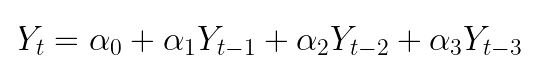

That is, suppose, if Y_t is the current series and Y_t-1 is the lag 1 of Y, then the partial autocorrelation of lag 3 (Y_t-3) is the coefficient $\alpha_3$ of Y_t-3 in the above equation.

Good. Now, how to find the number of AR terms?

Any autocorrelation in a stationarized series can be rectified by adding enough AR terms. So, we initially take the order of AR term to be equal to as many lags that crosses the significance limit in the PACF plot.

E:\Python_3.10\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


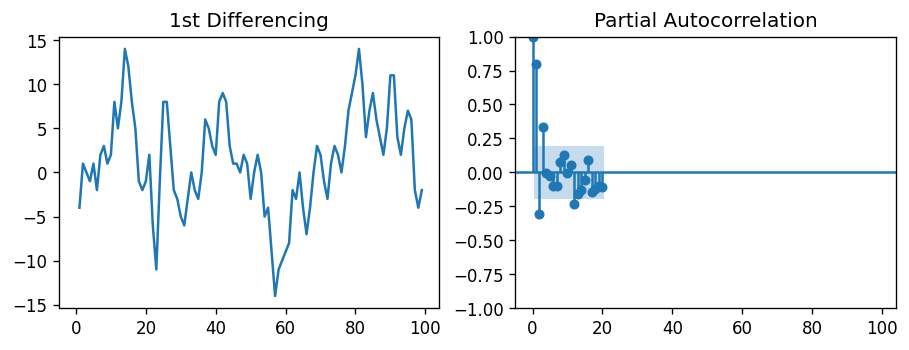

In [71]:
# PACF plot of 1st differenced series
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(df.value.diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,5))
plot_pacf(df.value.diff().dropna(), ax=axes[1])

plt.show()

You can observe that the PACF lag 1 is quite significant since is well above the significance line. Lag 2 turns out to be significant as well, slightly managing to cross the significance limit (blue region). But I am going to be conservative and tentatively fix the p as 1.

# 7. How to find the order of the MA term (q)

Just like how we looked at the PACF plot for the number of AR terms, you can look at the ACF plot for the number of MA terms. An MA term is technically, the error of the lagged forecast.

The ACF tells how many MA terms are required to remove any autocorrelation in the stationarized series.

Let’s see the autocorrelation plot of the differenced series.

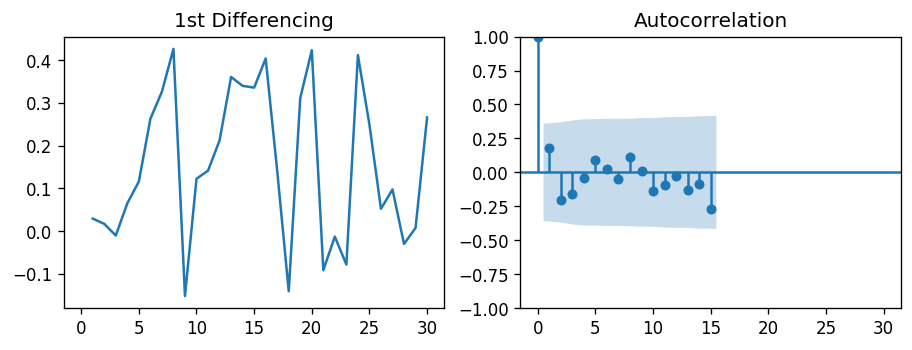

In [72]:
import pandas as pd
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

# Import data
df = pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/austa.csv')

fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(df.value.diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,1.2))
plot_acf(df.value.diff().dropna(), ax=axes[1])

plt.show()

Couple of lags are well above the significance line. So, let’s tentatively fix q as 2. When in doubt, go with the simpler model that sufficiently explains the Y.

# 8. How to handle if a time series is slightly under or over differenced

It may so happen that your series is slightly under differenced, that differencing it one more time makes it slightly over-differenced.

How to handle this case?

If your series is slightly under differenced, adding one or more additional AR terms usually makes it up. Likewise, if it is slightly over-differenced, try adding an additional MA term.

# 9. How to build the ARIMA Model
Now that you’ve determined the values of p, d and q, you have everything needed to fit the ARIMA model. Let’s use the ARIMA() implementation in statsmodels package.  (** You can also check out the free video lesson on forecasting restaurant visitors with ARIMA and then check how to test and improve the model)

In [73]:
from statsmodels.tsa.arima.model import ARIMA

# 1,1,2 ARIMA Model
model = ARIMA(df.value, order=(1,1,2))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                   31
Model:                 ARIMA(1, 1, 2)   Log Likelihood                   8.312
Date:                Tue, 31 May 2022   AIC                             -8.624
Time:                        16:46:35   BIC                             -3.020
Sample:                             0   HQIC                            -6.831
                                 - 31                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9998      0.038     26.639      0.000       0.926       1.073
ma.L1         -0.6954      1.316     -0.528      0.597      -3.274       1.884
ma.L2         -0.2901      0.495     -0.586      0.5

E:\Python_3.10\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
E:\Python_3.10\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


The model summary reveals a lot of information. The table in the middle is the coefficients table where the values under ‘coef’ are the weights of the respective terms.

Notice here the coefficient of the MA2 term is close to zero and the P-Value in ‘P>|z|’ column is highly insignificant. It should ideally be less than 0.05 for the respective X to be significant.

So, let’s rebuild the model without the MA2 term.

In [74]:
# 1,1,1 ARIMA Model
model = ARIMA(df.value, order=(1,1,1))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                   31
Model:                 ARIMA(1, 1, 1)   Log Likelihood                   7.328
Date:                Tue, 31 May 2022   AIC                             -8.657
Time:                        16:46:45   BIC                             -4.453
Sample:                             0   HQIC                            -7.312
                                 - 31                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9998      0.018     56.529      0.000       0.965       1.034
ma.L1         -0.9845      0.757     -1.300      0.193      -2.468       0.499
sigma2         0.0329      0.030      1.084      0.2

The model AIC has reduced, which is good. The P Values of the AR1 and MA1 terms have improved and are highly significant (<< 0.05).

Let’s plot the residuals to ensure there are no patterns (that is, look for constant mean and variance).


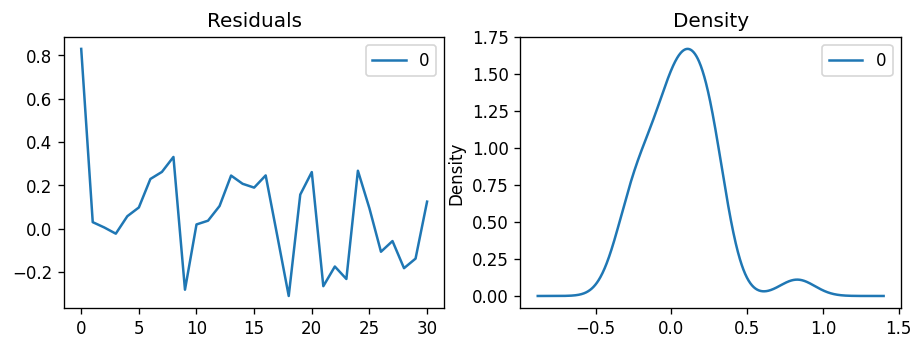

In [75]:
# Plot residual errors
residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

The residual errors seem fine with near zero mean and uniform variance. Let’s plot the actuals against the fitted values using plot_predict().

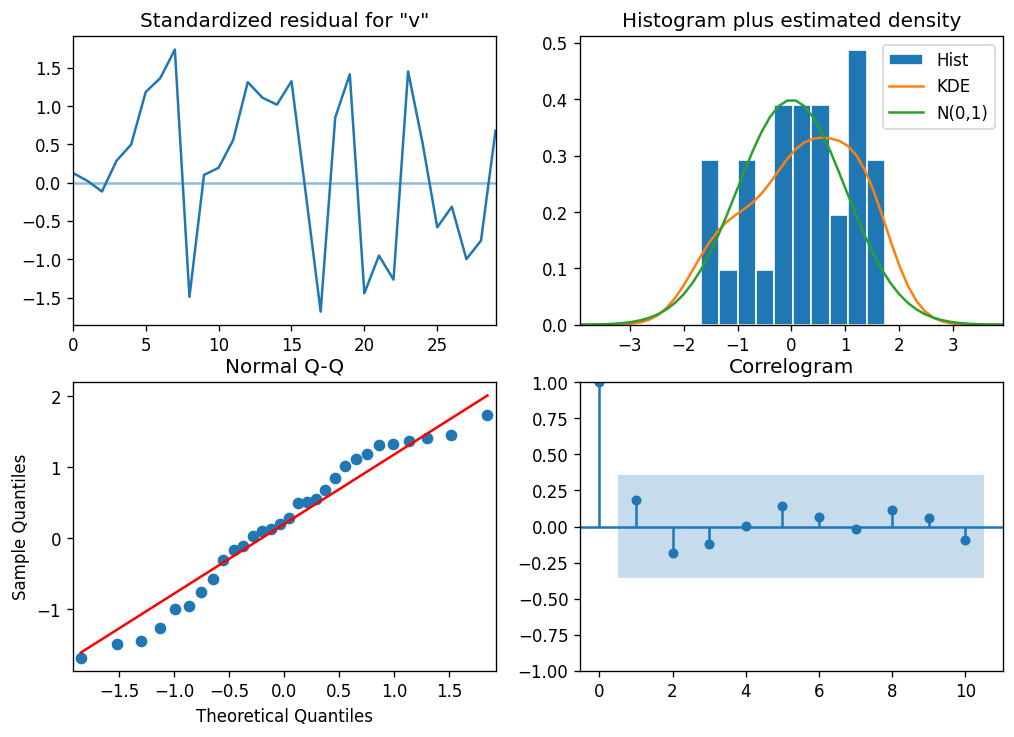

In [78]:
# Actual vs Fitted
# Actual vs Fitted
plt.rcParams.update({'figure.figsize':(10,7)})

model_fit.plot_diagnostics()
plt.show()

When you set dynamic=False the in-sample lagged values are used for prediction.

That is, the model gets trained up until the previous value to make the next prediction. This can make the fitted forecast and actuals look artificially good.

So, we seem to have a decent ARIMA model. But is that the best?

Can’t say that at this point because we haven’t actually forecasted into the future and compared the forecast with the actual performance.

So, the real validation you need now is the Out-of-Time cross-validation.

# 10. How to do find the optimal ARIMA model manually using Out-of-Time Cross validation

In Out-of-Time cross-validation, you take few steps back in time and forecast into the future to as many steps you took back. Then you compare the forecast against the actuals.

To do out-of-time cross-validation, you need to create the training and testing dataset by splitting the time series into 2 contiguous parts in approximately 75:25 ratio or a reasonable proportion based on time frequency of series.

Why am I not sampling the training data randomly you ask?

That’s because the order sequence of the time series should be intact in order to use it for forecasting.

In [94]:
from statsmodels.tsa.stattools import acf

# Create Training and Test
train = df.value[:25]
test = df.value[25:]

You can now build the ARIMA model on training dataset, forecast and plot it.

In [97]:
model = ARIMA(train, order=(1, 1, 1))  
fitted = model.fit()  #disp=-1
fc= fitted.forecast(15, alpha=0.05)  # 95% conf

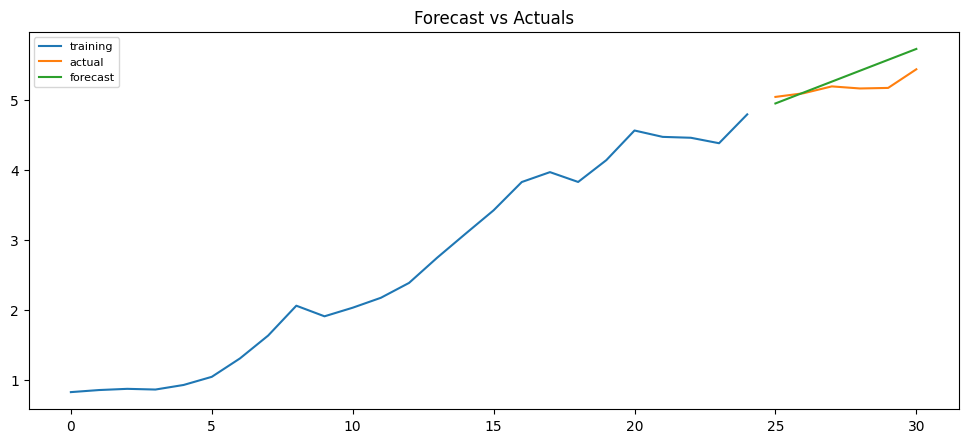

In [98]:
# Build Model
# model = ARIMA(train, order=(3,2,1))  
#model = ARIMA(train, order=(1, 1, 1))  
#fitted = model.fit()  #disp=-1

# Forecast
#fc, se, conf = fitted.forecast(15, alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test.index)
#lower_series = pd.Series(fc, index=test.index)
#upper_series = pd.Series(fc, index=test.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

From the chart, the ARIMA(1,1,1) model seems to give a directionally correct forecast. And the actual observed values lie within the 95% confidence band. That seems fine.

But each of the predicted forecasts is consistently below the actuals. That means, by adding a small constant to our forecast, the accuracy will certainly improve. So, there is definitely scope for improvement.

So, what I am going to do is to increase the order of differencing to two, that is set d=2 and iteratively increase p to up to 5 and then q up to 5 to see which model gives least AIC and also look for a chart that gives closer actuals and forecasts.

While doing this, I keep an eye on the P values of the AR and MA terms in the model summary. They should be as close to zero, ideally, less than 0.05.

                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                   25
Model:                 ARIMA(3, 2, 1)   Log Likelihood                   4.703
Date:                Tue, 31 May 2022   AIC                              0.595
Time:                        17:12:48   BIC                              6.272
Sample:                             0   HQIC                             2.022
                                 - 25                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2178      0.247      0.881      0.379      -0.267       0.702
ar.L2         -0.1923      0.306     -0.628      0.530      -0.793       0.408
ar.L3         -0.0942      0.216     -0.437      0.6

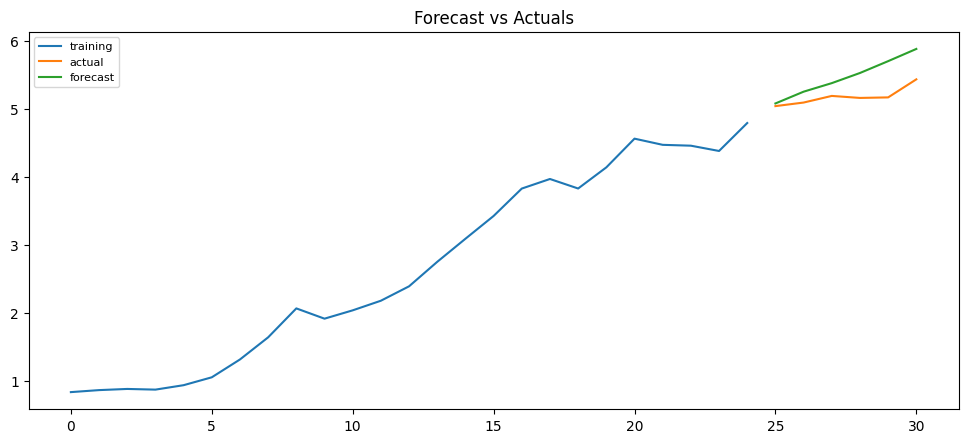

In [99]:
# Build Model
model = ARIMA(train, order=(3, 2, 1))  
fitted = model.fit()  
print(fitted.summary())

# Forecast
fc = fitted.forecast(15, alpha=0.05)  # 95% conf

#fc, se, conf = fitted.forecast(15, alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test.index)
#lower_series = pd.Series(conf[:, 0], index=test.index)
#upper_series = pd.Series(conf[:, 1], index=test.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

The AIC has reduced to 440 from 515. Good. The P-values of the X terms are less the < 0.05, which is great.

So overall it’s much better.

Ideally, you should go back multiple points in time, like, go back 1, 2, 3 and 4 quarters and see how your forecasts are performing at various points in the year.

Here’s a great practice exercise: Try to go back 27, 30, 33, 36 data points and see how the forcasts performs. The forecast performance can be judged using various accuracy metrics discussed next.

# 11. Accuracy Metrics for Time Series Forecast

* Mean Absolute Percentage Error (MAPE)
* Mean Error (ME)
* Mean Absolute Error (MAE)
* Mean Percentage Error (MPE)
* Root Mean Squared Error (RMSE)
* Lag 1 Autocorrelation of Error (ACF1)
* Correlation between the Actual and the Forecast (corr)
* Min-Max Error (minmax)

Typically, if you are comparing forecasts of two different series, the MAPE, Correlation and Min-Max Error can be used.


Why not use the other metrics?

Because only the above three are percentage errors that vary between 0 and 1. That way, you can judge how good is the forecast irrespective of the scale of the series.

The other error metrics are quantities. That implies, an RMSE of 100 for a series whose mean is in 1000’s is better than an RMSE of 5 for series in 10’s. So, you can’t really use them to compare the forecasts of two different scaled time series.


In [100]:
# Accuracy metrics
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    acf1 = acf(fc-test)[1]                      # ACF1
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 'acf1':acf1, 
            'corr':corr, 'minmax':minmax})

forecast_accuracy(fc, test.values)

ValueError: operands could not be broadcast together with shapes (15,) (6,) 

Around 2.2% MAPE implies the model is about 97.8% accurate in predicting the next 15 observations.

Now you know how to build an ARIMA model manually.

But in industrial situations, you will be given a lot of time series to be forecasted and the forecasting exercise be repeated regularly.

So we need a way to automate the best model selection process.

# 12. How to do Auto Arima Forecast in Python


Like R’s popular auto.arima() function, the pmdarima package provides auto_arima() with similar functionality.

auto_arima() uses a stepwise approach to search multiple combinations of p,d,q parameters and chooses the best model that has the least AIC.

In [101]:
from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm

df = pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/wwwusage.csv', names=['value'], header=0)

model = pm.auto_arima(df.value, start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=525.587, Time=0.04 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=533.474, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=532.437, Time=0.02 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=525.893, Time=0.03 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=531.477, Time=0.01 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=515.248, Time=0.04 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=513.459, Time=0.03 sec
 ARIMA(3,2,0)(0,0,0)[0] intercept   : AIC=515.284, Time=0.03 sec
 ARIMA(3,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.22 sec
 ARIMA(2,2,0)(0,0,0)[0]             : AIC=511.465, Time=0.02 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=530.444, Time=0.01 sec
 ARIMA(3,2,0)(0,0,0)[0]             : AIC=513.291, Time=0.03 sec
 ARIMA(2,2,1)(0,0,0)[0]             : AIC=513.256, Time=0.02 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=523.592, Time=0.02 sec
 ARIMA(3,2,1)(0,0,0)[0]             : AIC=inf, Time

# 13. How to interpret the residual plots in ARIMA model

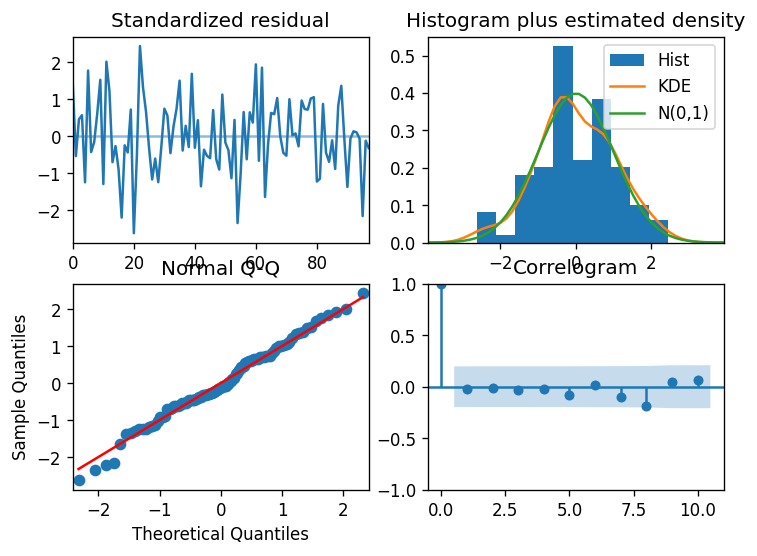

In [102]:
model.plot_diagnostics(figsize=(7,5))
plt.show()

Top left: The residual errors seem to fluctuate around a mean of zero and have a uniform variance.

Top Right: The density plot suggest normal distribution with mean zero.

Bottom left: All the dots should fall perfectly in line with the red line. Any significant deviations would imply the distribution is skewed.

Bottom Right: The Correlogram, aka, ACF plot shows the residual errors are not autocorrelated. Any autocorrelation would imply that there is some pattern in the residual errors which are not explained in the model. So you will need to look for more X’s (predictors) to the model.

Overall, it seems to be a good fit. Let’s forecast.

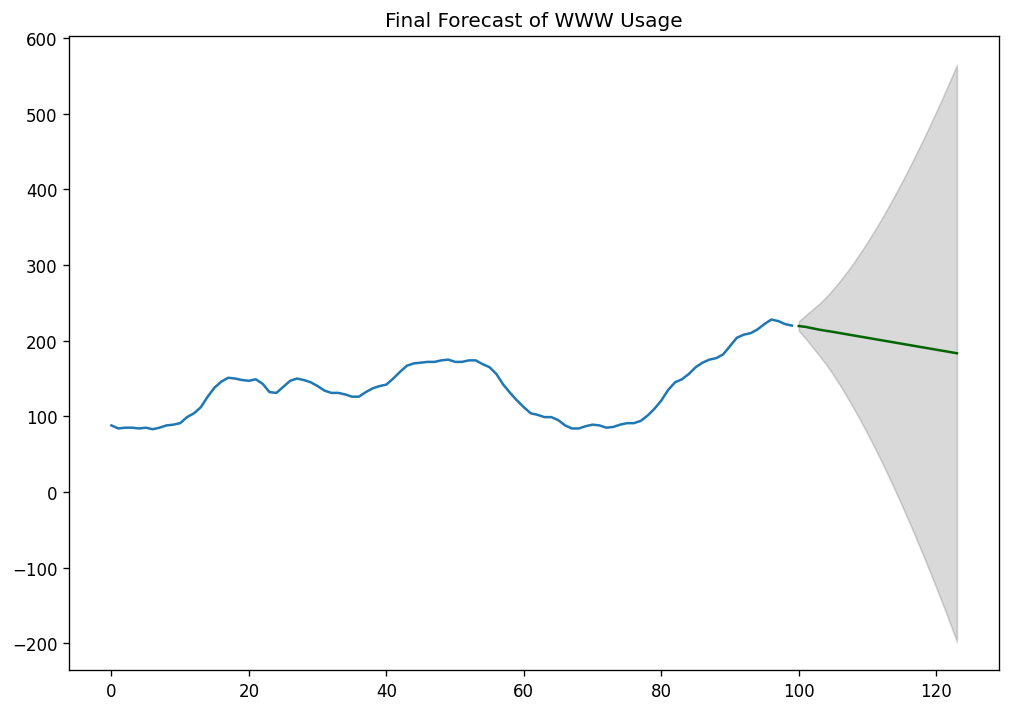

In [103]:
# Forecast
n_periods = 24
fc, confint = model.predict(n_periods=n_periods, return_conf_int=True)
index_of_fc = np.arange(len(df.value), len(df.value)+n_periods)

# make series for plotting purpose
fc_series = pd.Series(fc, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

# Plot
plt.plot(df.value)
plt.plot(fc_series, color='darkgreen')
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)

plt.title("Final Forecast of WWW Usage")
plt.show()

# 14. How to automatically build SARIMA model in python

The problem with plain ARIMA model is it does not support seasonality.

If your time series has defined seasonality, then, go for SARIMA which uses seasonal differencing.

Seasonal differencing is similar to regular differencing, but, instead of subtracting consecutive terms, you subtract the value from previous season.

So, the model will be represented as SARIMA(p,d,q)x(P,D,Q), where, P, D and Q are SAR, order of seasonal differencing and SMA terms respectively and 'x' is the frequency of the time series.

If your model has well defined seasonal patterns, then enforce D=1 for a given frequency ‘x’.

Here’s some practical advice on building SARIMA model:

As a general rule, set the model parameters such that D never exceeds one. And the total differencing ‘d + D’ never exceeds 2. Try to keep only either SAR or SMA terms if your model has seasonal components.

Let’s build an SARIMA model on 'a10' – the drug sales dataset.

In [ ]:
# Import
data = pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/a10.csv', parse_dates=['date'], index_col='date')

# Plot
fig, axes = plt.subplots(2, 1, figsize=(10,5), dpi=100, sharex=True)

# Usual Differencing
axes[0].plot(data[:], label='Original Series')
axes[0].plot(data[:].diff(1), label='Usual Differencing')
axes[0].set_title('Usual Differencing')
axes[0].legend(loc='upper left', fontsize=10)


# Seasinal Dei
axes[1].plot(data[:], label='Original Series')
axes[1].plot(data[:].diff(12), label='Seasonal Differencing', color='green')
axes[1].set_title('Seasonal Differencing')
plt.legend(loc='upper left', fontsize=10)
plt.suptitle('a10 - Drug Sales', fontsize=16)
plt.show()

As you can clearly see, the seasonal spikes is intact after applying usual differencing (lag 1). Whereas, it is rectified after seasonal differencing.

Let’s build the SARIMA model using pmdarima‘s auto_arima(). To do that, you need to set seasonal=True, set the frequency m=12 for month wise series and enforce D=1.

In [ ]:
# !pip3 install pyramid-arima
import pmdarima as pm

# Seasonal - fit stepwise auto-ARIMA
smodel = pm.auto_arima(data, start_p=1, start_q=1,
                         test='adf',
                         max_p=3, max_q=3, m=12,
                         start_P=0, seasonal=True,
                         d=None, D=1, trace=True,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)

smodel.summary()

The model has estimated the AIC and the P values of the coefficients look significant. Let’s look at the residual diagnostics plot.

The best model SARIMAX(3, 0, 0)x(0, 1, 1, 12) has an AIC of 528.6 and the P Values are significant.

Let’s forecast for the next 24 months.

In [ ]:
# Forecast
n_periods = 24
fitted, confint = smodel.predict(n_periods=n_periods, return_conf_int=True)
index_of_fc = pd.date_range(data.index[-1], periods = n_periods, freq='MS')

# make series for plotting purpose
fitted_series = pd.Series(fitted, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

# Plot
plt.plot(data)
plt.plot(fitted_series, color='darkgreen')
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)

plt.title("SARIMA - Final Forecast of a10 - Drug Sales")
plt.show()

# 15. How to build SARIMAX Model with exogenous variable

But for the sake of completeness, let’s try and force an external predictor, also called, ‘exogenous variable’ into the model. This model is called the SARIMAX model.

The only requirement to use an exogenous variable is you need to know the value of the variable during the forecast period as well.

For the sake of demonstration, I am going to use the seasonal index from the classical seasonal decomposition on the latest 36 months of data.

Why the seasonal index? Isn’t SARIMA already modeling the seasonality, you ask?

You are correct.

But also, I want to see how the model looks if we force the recent seasonality pattern into the training and forecast.

Secondly, this is a good variable for demo purpose. So you can use this as a template and plug in any of your variables into the code. The seasonal index is a good exogenous variable because it repeats every frequency cycle, 12 months in this case.

So, you will always know what values the seasonal index will hold for the future forecasts.


In [ ]:
# Import Data
data = pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/a10.csv', parse_dates=['date'], index_col='date')

In [ ]:
# Compute Seasonal Index
from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse

# multiplicative seasonal component
result_mul = seasonal_decompose(data['value'][-36:],   # 3 years
                                model='multiplicative', 
                                extrapolate_trend='freq')

seasonal_index = result_mul.seasonal[-12:].to_frame()
seasonal_index['month'] = pd.to_datetime(seasonal_index.index).month

# merge with the base data
data['month'] = data.index.month
df = pd.merge(data, seasonal_index, how='left', on='month')
df.columns = ['value', 'month', 'seasonal_index']
df.index = data.index  # reassign the index.

The exogenous variable (seasonal index) is ready. Let’s build the SARIMAX model.

In [ ]:
import pmdarima as pm

# SARIMAX Model
sxmodel = pm.auto_arima(df[['value']], exogenous=df[['seasonal_index']],
                           start_p=1, start_q=1,
                           test='adf',
                           max_p=3, max_q=3, m=12,
                           start_P=0, seasonal=True,
                           d=None, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)

sxmodel.summary()

So, we have the model with the exogenous term. But the coefficient is very small for x1, so the contribution from that variable will be negligible. Let’s forecast it anyway.

We have effectively forced the latest seasonal effect of the latest 3 years into the model instead of the entire history.

Alright let’s forecast into the next 24 months. For this, you need the value of the seasonal index for the next 24 months.

In [ ]:
# Forecast
n_periods = 24
fitted, confint = sxmodel.predict(n_periods=n_periods, 
                                  exogenous=np.tile(seasonal_index.value, 2).reshape(-1,1), 
                                  return_conf_int=True)

index_of_fc = pd.date_range(data.index[-1], periods = n_periods, freq='MS')

# make series for plotting purpose
fitted_series = pd.Series(fitted, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

# Plot
plt.plot(data['value'])
plt.plot(fitted_series, color='darkgreen')
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)

plt.title("SARIMAX Forecast of a10 - Drug Sales")
plt.show()

# 16. Practice Exercises

In the AirPassengers dataset, go back 12 months in time and build the SARIMA forecast for the next 12 months.

Is the series stationary? If not what sort of differencing is required?
What is the order of your best model?
What is the AIC of your model?
What is the MAPE achieved in OOT cross-validation?
What is the order of the best model predicted by auto_arima() method?